<p style="margin: 0; text-align:right;">2022-1 · Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>

## Métodos supervisados

En esta práctica veremos diferentes métodos supervisados y trataremos de optimizar diferentes métricas. Veremos como los diferentes modelos clasifican los puntos y con cuales obtenemos mayor precisión. Después aplicaremos todo lo que hemos aprendido hasta ahora a un dataset nuevo simulando un caso práctico real.

1. [Exploración de algoritmos supervisados](#ej1)
        1.0. Carga de datos
        1.1. Naive-Bayes
        1.2. K vecinos más próximos
        1.3. Support vector machines
        1.4. Árboles de decisión
        1.5. Random forest / Gradient boosting
2. [Implementación del caso práctico](#ej2)
        2.0. Carga de datos
        2.1. Preprocesamiento de los datos
        2.2. Análisis descriptivo
        2.3. Entrenamiento del modelo
        2.4. Predicción de nuevos casos
        2.5. BONUS

<div class="alert alert-block alert-info">
    <strong>Nombre y apellidos: Eugenia Bezek</strong>
</div>

In [1]:
from collections import Counter
import json
import re

import nltk
import numpy as np 
import pandas as pd
import pickle
import seaborn as sns

from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# UMAP para la reducción de dimensionalidad
import umap

# Visualización.
from dtreeviz.trees import dtreeviz
import graphviz
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

%matplotlib inline

nltk.download('stopwords');

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eugeniabezek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<a id='ej1'></a>
# 1. Exploración de algoritmos supervisados

## 1.0. Carga de datos

El conjunto de datos Fashion MNIST proporcionado por Zalando consta de 70.000 imágenes con 10 clases diferentes de ropa repartidas uniformemente. No obstante, para esta práctica utilizaremos únicamente un subconjunto de 5.000 imágenes que consiste en 1.000 imágenes de 5 clases diferentes.

Las imágenes tienen una resolución de 28x28 píxeles en escala de grises, por lo que se pueden representar utilizando un vector de 784 posiciones.

El siguiente código cargará las 5.000 imágenes en la variable images y las correspondientes etiquetas (en forma numérica) en la variable labels. Podemos comprobar que la carga ha sido correcta obteniendo las dimensiones de estas dos variables.

In [2]:
with open("data.pickle", "rb") as f:
    data = pickle.load(f)
    
X = data["images"]
y = data["labels"]
n_classes = 5
labels = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat"]

print("Dimensiones del vector de imágenes: {}".format(X.shape))
print("Dimensiones del vector de etiquetas: {}".format(y.shape))

Dimensiones del vector de imágenes: (5000, 784)
Dimensiones del vector de etiquetas: (5000,)


Con el siguiente código podemos ver un ejemplo de imagen de cada una de las clases. Para ello reajustamos el vector de 784 dimensiones que representa cada imagen en una matriz de tamaño 28x28 y la transponemos para mostrarla:

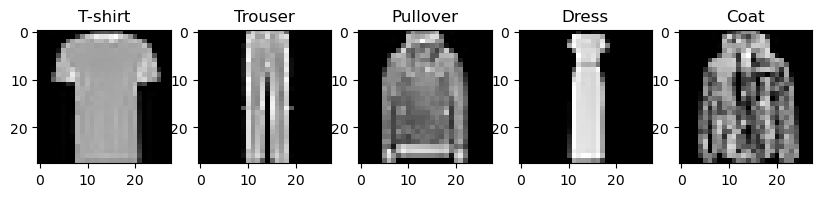

In [3]:
fig, ax = plt.subplots(1, n_classes, figsize=(10,10))

idxs = [np.where(y == i)[0] for i in range(n_classes)]

for i in range(n_classes):
    k = np.random.choice(idxs[i])
    ax[i].imshow(X[k].reshape(28, 28), cmap="gray")
    ax[i].set_title("{}".format(labels[i]))

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> 

Dividid el _dataset_ en dos subconjuntos, __*train*__ (80% de los datos) y __*test*__ (20% de los datos). Nombrad los conjuntos como: X_train, X_test, y_train, y_test. Utilizad la opción `random_state = 24`.
    
Podéis utilizar la implementación `train_test_split` de `sklearn`.
    
</div>

In [4]:
#Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 24)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(4000, 784) (4000,)
(1000, 784) (1000,)


Para poder visualizar los resultados de cada algoritmo supervisado, reduciremos el dataset anterior a dos dimensiones.

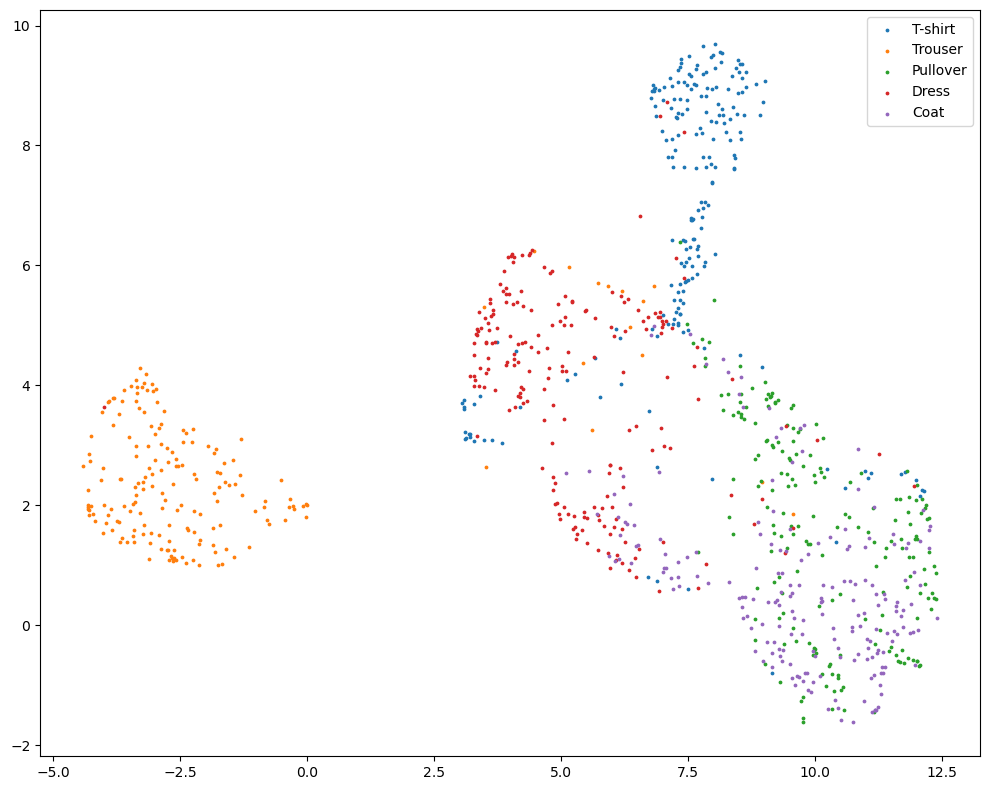

In [5]:
model = umap.UMAP(n_components=2, random_state=42)
model.fit(X_train)
X_train_projection = model.transform(X_train)
X_test_projection = model.transform(X_test)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for i in range(n_classes):
    ax.scatter(X_test_projection[y_test == i,0], X_test_projection[y_test == i,1], s=3, label=labels[i])
plt.legend()
plt.tight_layout()

A lo largo de los ejercicios aprenderemos a ver gráficamente las fronteras de decisión que nos devuelven los diferentes modelos. Para ello utilizaremos la función definida a continuación, que sigue los siguientes pasos:

   - Crear una [meshgrid](https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html) con los valores mínimo y máximo de 'x' e 'y'.
   - Predecir el clasificador con los valores de la _meshgrid_.
   - Hacer un _reshape_ de los datos para tener el formato correspondiente.
  
Una vez hecho esto, ya podemos hacer el gráfico de las fronteras de decisión y añadir los puntos reales. Así veremos las áreas que el modelo considera que son de una clase y las que considera que son de otra. Al poner encima los puntos veremos si los clasifica correctamente en el área que les corresponde.

In [6]:
# vamos a crear la meshgrid con los valores mínimos y máximos de los ejes x e y
x_min, x_max = X_test_projection[:, 0].min() - 1, X_test_projection[:, 0].max() + 1
y_min, y_max = X_test_projection[:, 1].min() - 1, X_test_projection[:, 1].max() + 1

# definimos la función que visualizará la frontera de decisión
def plot_decision_boundaries(model, X_test_projection, y_test):
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                         np.arange(y_min, y_max, 0.05))
    
    # precedimos con el clasificador con los valores de la meshgrid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # definimos los colores (uno para cada clase)
    cmap_light = ListedColormap(['gainsboro','lightgreen','peachpuff','lightcyan', 'pink'])
    cmap_bold = ['grey','g','sandybrown','c','palevioletred']
    
    # dibujamos las fronteras
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(20,10))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # dibujamos los puntos
    for i in range(n_classes):
        plt.scatter(X_test_projection[y_test == i,0], X_test_projection[y_test == i,1], 
                    s=3, label=labels[i], c=cmap_bold[i])
    plt.legend()
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())  

### 1.1. Gaussian Naïve Bayes

El objetivo de este primer ejercicio es entender el funcionamiento del algoritmo Naïve-Bayes, un algoritmo peculiar ya que se basa completamente en teoría de probabilidades.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Con el dataset de _train_, entrenad un modelo Naïve-Bayes y representad gráficamente la frontera de decisión con el de _test_. Podéis utilizar el clasificador **GaussianNB** de `sklearn`.
    
Calculad el _accuracy_ del modelo obtenido sobre _train_ y _test_ y la matriz de confusión sobre _test_. Podéis utilizar `accuracy_score` y `confusion_matrix` del paquet `metrics` de `sklearn`.
</div>

In [7]:
#instancio el clasificador:
clfBayes = GaussianNB()
#Entrenamos el modelo
clfBayes.fit(X_train_projection, y_train)

#Predecimos los labels del conjunto de testeo:
y_pred = clfBayes.predict(X_test_projection)

print('Model accuracy score: {0:0.2f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score: 0.72


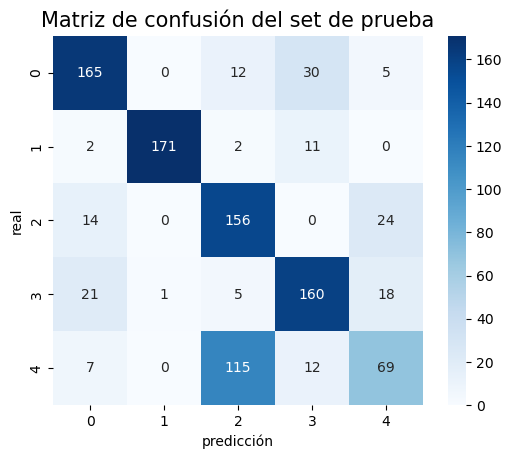

In [8]:
#confusion matrix
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt="d", cmap='Blues', square=True)
plt.title('Matriz de confusión del set de prueba', fontsize = 15)
plt.xlabel("predicción")
plt.ylabel("real")
plt.show()

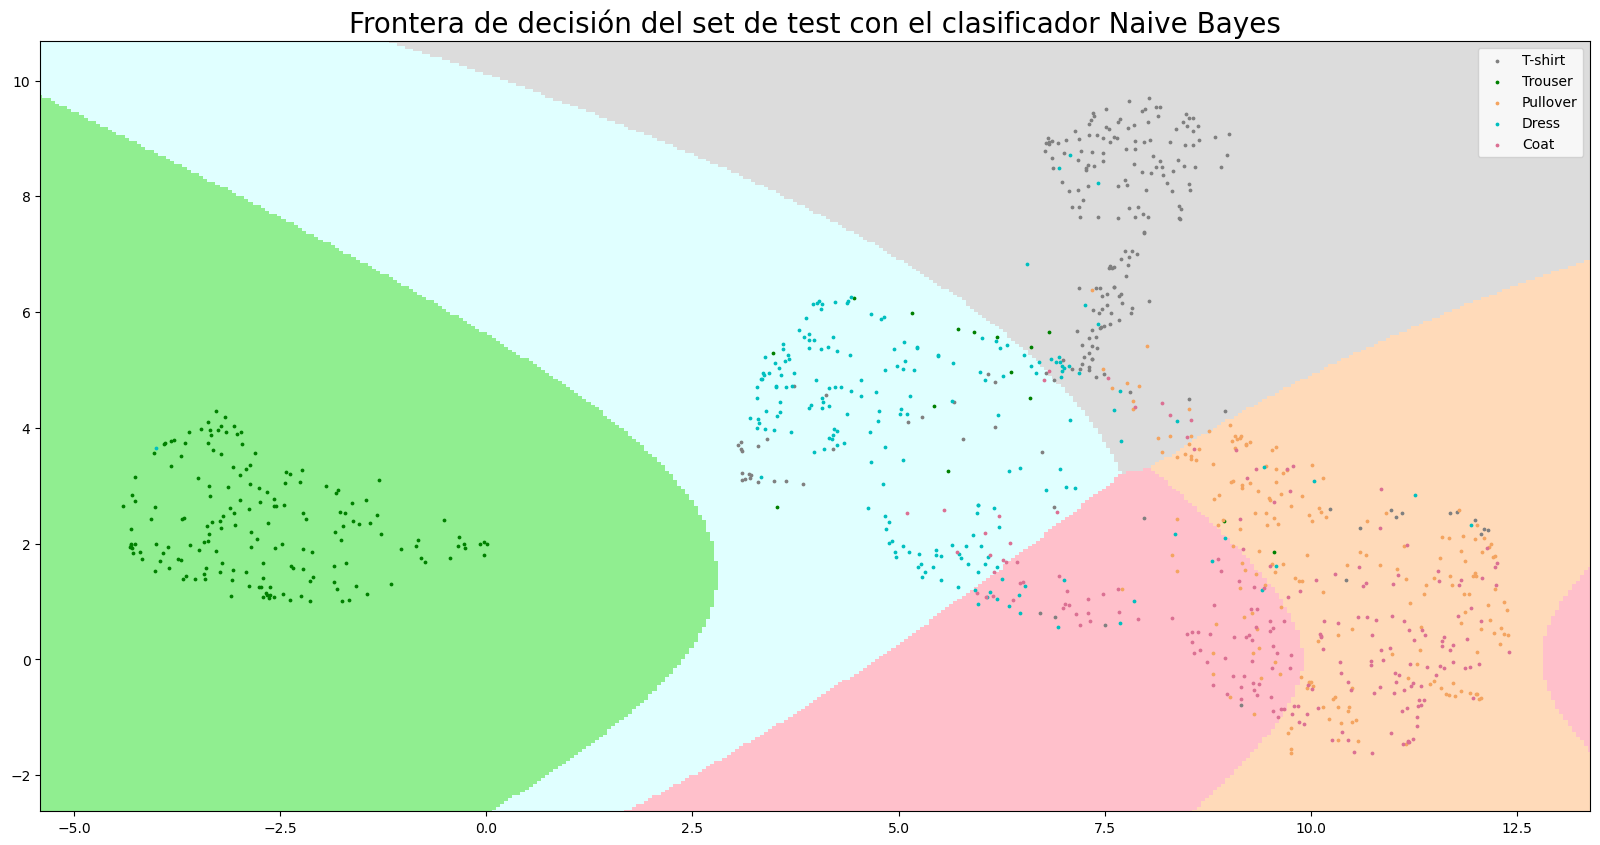

In [9]:
plot_decision_boundaries(clfBayes,X_test_projection, y_test)
plt.title('Frontera de decisión del set de test con el clasificador Naive Bayes', fontsize = 20)
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> 
  
Análisis del ejercicio.

   - ¿Cómo son las fronteras de decisión? ¿Tiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¿Cómo son las predicciones obtenidas sobre el conjunto de test?
</div>

Las fronteras de decisión obtenidas son no lineales y se debe al uso de la curva normal o gaussiana como función de distribución de X. Esto hace que la fórmula para calcular la probabilidad condicional de cada nueva instancia no sea lineal. 

Las predicciones obtenidas indican que la clase mejor clasificada por el modelo fue la número 1, Trousers, que es la de color verde, lo cual tiene sentido ya que es la imagen más distinta al resto.
La clase que clasificó de forma menos precisa fue la 4, 'Coat' la cual la confundió la mayor cantidad de veces con la clase 2 'Pullover', dado que las imágenes que conforman estas clases son muy similares. El accuracy total del modelo es de 0,72

### 1.2. KNN

El objetivo de este segundo ejercicio es entender el funcionamiento del KNN, intuir sus principales ventajas o desventajas y entender la influencia de los parámetros de los que está compuesto.

K-Nearest-Neighbor es un algoritmo basado en instancia de tipo supervisado. 

Vamos a ver qué significa esto:

  - Supervisado: tenemos etiquetado nuestro conjunto de datos de entrenamiento, con la clase o resultado esperado.
  - Basado en instancia (_Lazy Learning_): Esto significa que nuestro algoritmo no aprende explícitamente un modelo (como por ejemplo en Regresión Logística o árboles de decisión), sino que memoriza las instancias de entrenamiento que son utilizadas como "conocimiento" para la fase de predicción.

¿Cómo funciona KNN?

  - Calculamos la distancia entre el ítem a clasificar y los demás ítems del dataset de entrenamiento.
  - Seleccionamos los "k" elementos más cercanos, es decir, con menor distancia, según la distancia que utilizamos (euclídea, coseno, manhattan, etc).
  - Por último realizamos una "votación de mayoría" entre los k puntos: los de la clase que "dominan" decidirán su clasificación final.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Con el dataset de _train_, entrenad un modelo KNN con `n_neighbors = 2` y representad gráficamente la frontera de decisión con el de _test_.
    
Podéis utilizar el clasificador **KNeighborsClassifier** de `sklearn`.
</div>

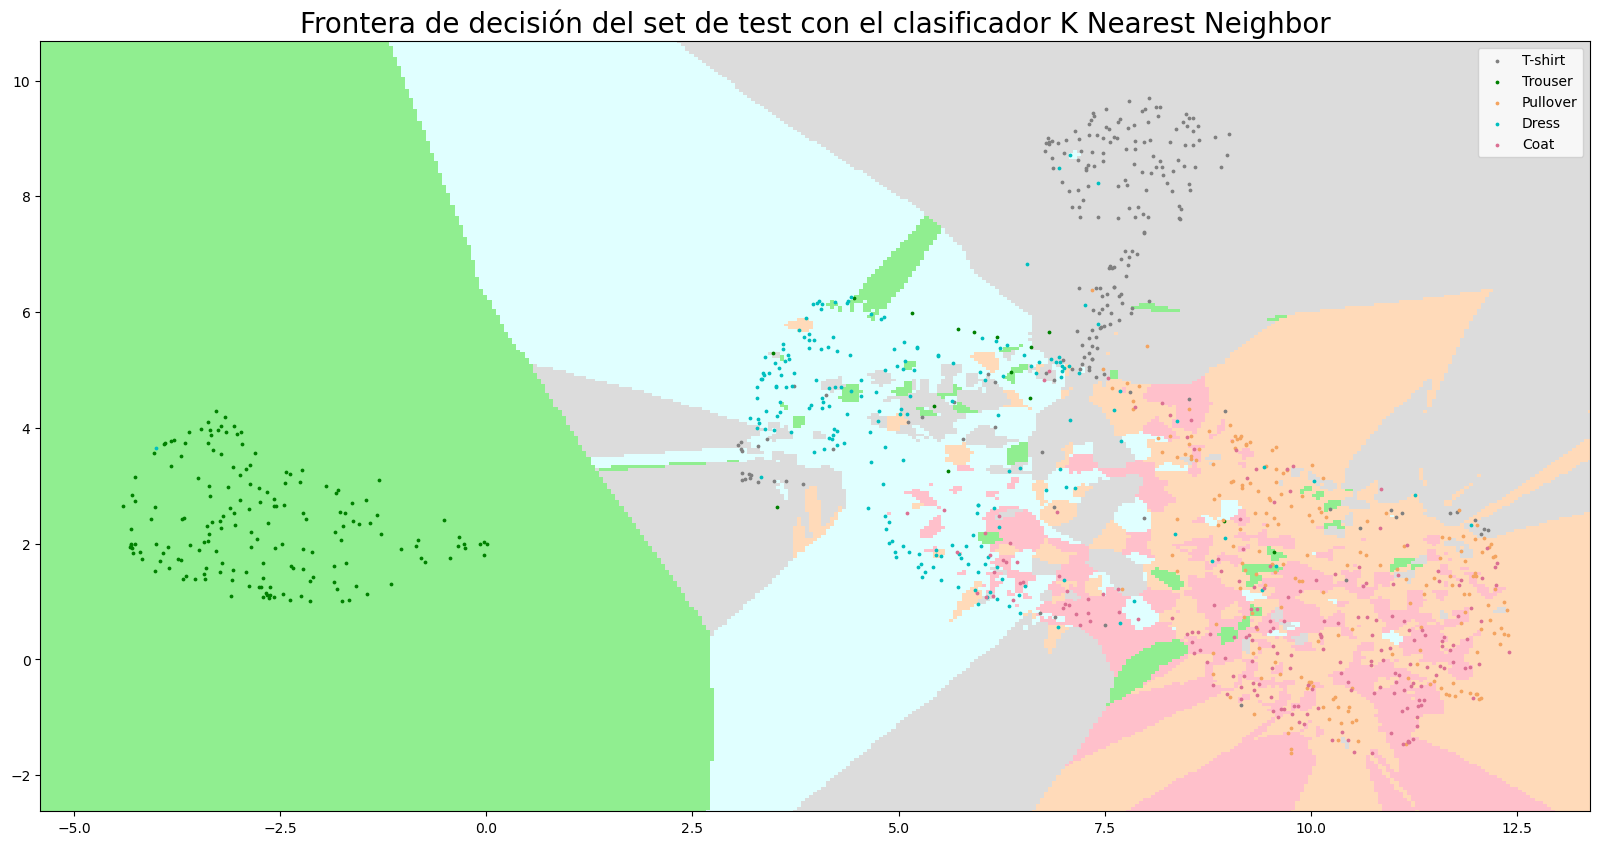

In [11]:
import warnings
warnings.filterwarnings('ignore')

clfKNeighbor = KNeighborsClassifier(n_neighbors=2)
clfKNeighbor.fit(X_train_projection, y_train)

#Predecimos los labels del conjunto de testeo:
y_pred = clfKNeighbor.predict(X_test_projection)


#Grafico de la frontera de decision:
plot_decision_boundaries(clfKNeighbor,X_test_projection, y_test)
plt.title('Frontera de decisión del set de test con el clasificador K Nearest Neighbor', fontsize = 20)
plt.show()

En el modelo entrenado, hemos fijado el parámetro `n_neighbors` de forma arbitraria. Pero podría ser que con otro valor obtuviéramos una mejor predicción.

Para conocer el valor óptimo de los parámetros de un modelo (_hyperparameter tunning_) se suele utilizar una búsqueda de rejilla (_grid search_). Es decir, entrenar un modelo para cada combinación de hiperparámetros posible y evaluarlo utilizando validación cruzada (_cross validation_) con 4 particiones estratificadas. Posteriormente, se elige la combinación de hiperparàmetres que mejores resultados haya obtenido.

En este caso sólo queremos optimizar un hiperparámetro:

   - 𝑘: el número de vecinos que se consideran para clasificar un nuevo ejemplo. Probaremos con todos los valores entre 1 y 10.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong>

Cálculo del valor óptimo del hiperparámetro _k_ (`n_neighbors`). Utilizad una búsqueda de rejilla con validación cruzada para encontrar el valor óptimo de _k_. Por cada valor, calculad su promedio y la desviación estándar. Implementad un _heatmap_ para visualizar la precisión según los diferentes valores del hiperparámetro.
    
Puede utilizar el módulo `GridSearchCV` de `sklearn` el cálculo del mejor hiperparámetro, y `heatmap` de `Seaborn`.
</div>

In [12]:
# Grilla para Grid Search
param_grid = {'n_neighbors':np.arange(1, 11)}
#Modelo a usar:
knn = KNeighborsClassifier()

model = GridSearchCV(knn, param_grid=param_grid, cv=4, scoring='accuracy')
model.fit(X_train_projection, y_train)
y_pred = model.predict(X_test_projection)

In [13]:
# Mejor estimador
print(model.best_estimator_)

KNeighborsClassifier(n_neighbors=9)


In [14]:
results = []
results.append(model.cv_results_['split0_test_score'])
results.append(model.cv_results_['split1_test_score'])
results.append(model.cv_results_['split2_test_score'])
results.append(model.cv_results_['split3_test_score'])
results.append(model.cv_results_['mean_test_score'])
results.append(model.cv_results_['std_test_score'])
results = np.asmatrix(results)
results

# creating a list of index names
index_values = ['Accuracy cv=1', 'Accuracy cv=2', 'Accuracy cv=3','Accuracy cv=4','Mean Accuracy','Standard Deviation']
     
# creating a list of column names
column_values = ['n_neighbors=1', 'n_neighbors=2', 'n_neighbors=3', 'n_neighbors=4','n_neighbors=5','n_neighbors=6'
                 ,'n_neighbors=7','n_neighbors=8','n_neighbors=9','n_neighbors=10']


# creating the dataframe
knn_df = pd.DataFrame(data = results, 
                  index = index_values, 
                  columns = column_values)
knn_df.head(6)

,n_neighbors=1,n_neighbors=2,n_neighbors=3,n_neighbors=4,n_neighbors=5,n_neighbors=6,n_neighbors=7,n_neighbors=8,n_neighbors=9,n_neighbors=10
Accuracy cv=1,0.741000,0.728000,0.767000,0.76800,0.773000,0.783000,0.781000,0.787000,0.790000,0.77800
Accuracy cv=2,0.750000,0.765000,0.793000,0.81000,0.820000,0.810000,0.811000,0.807000,0.811000,0.80600
Accuracy cv=3,0.752000,0.730000,0.783000,0.77700,0.792000,0.796000,0.806000,0.805000,0.814000,0.81100
Accuracy cv=4,0.751000,0.751000,0.776000,0.78300,0.789000,0.798000,0.816000,0.816000,0.821000,0.82000
Mean Accuracy,0.748500,0.743500,0.779750,0.78450,0.793500,0.796750,0.803500,0.803750,0.809000,0.80375
Standard Deviation,0.004387,0.015338,0.009523,0.01566,0.016919,0.009575,0.013463,0.010521,0.011554,0.01569


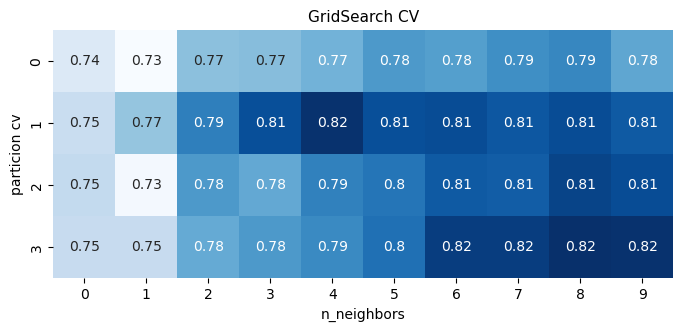

In [15]:
#HEATMAP CON LA PRECISION DEL MODELO PARA CADA N_NEIGHBOR TESTEADO:
m = []
m.append(model.cv_results_['split0_test_score'])
m.append(model.cv_results_['split1_test_score'])
m.append(model.cv_results_['split2_test_score'])
m.append(model.cv_results_['split3_test_score'])
m = np.array(m).reshape(4,10)
m = np.asmatrix(m)

#Matrix
plt.figure(figsize=(8,6))
sns.heatmap(m, annot=True, cmap='Blues', square=True, cbar=False)
plt.title('GridSearch CV', fontsize = 11)
plt.xlabel("n_neighbors")
plt.ylabel("particion cv")
plt.show()

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Con el mejor hiperparámetro encontrado, volved a entrenar un clasificador KNN (con _train_) y representar las fronteras de decisión con los puntos de _test_.
    
Calcular el _accuracy_ del modelo obtenido sobre _test_ y la matriz de confusión. Podéis utilizar `accuracy_score` y `confusion_matrix` de `metrics` de `sklearn`.
</div>

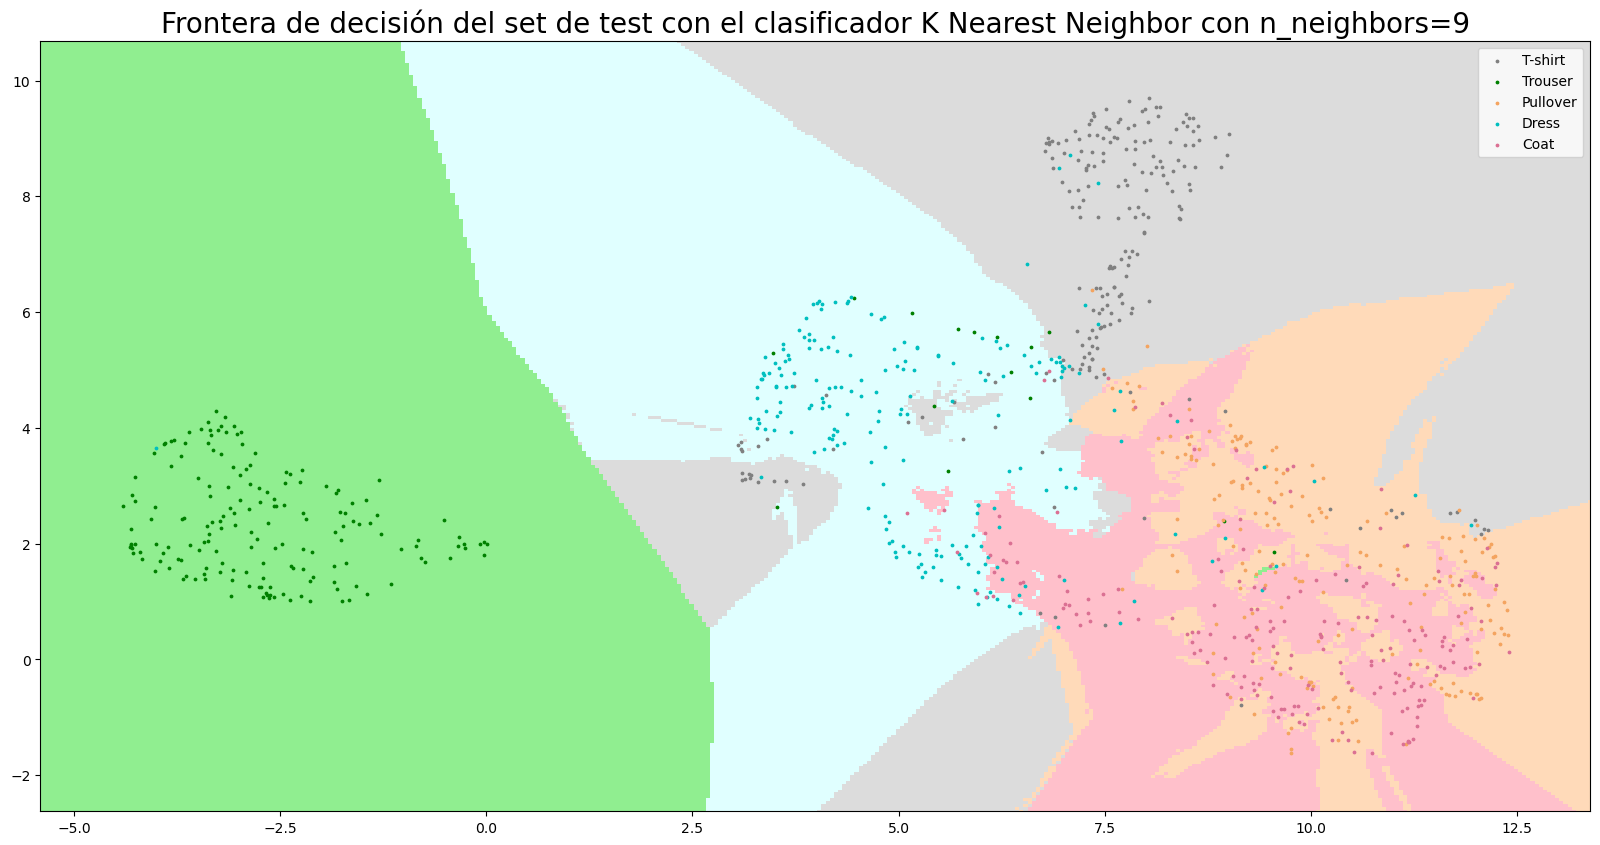

In [16]:
clfKNeighbor = KNeighborsClassifier(n_neighbors=9)
clfKNeighbor.fit(X_train_projection, y_train)

#Predecimos los labels del conjunto de testeo:
y_pred = clfKNeighbor.predict(X_test_projection)

#Grafico de la frontera de decision:
plot_decision_boundaries(clfKNeighbor,X_test_projection, y_test)
plt.title('Frontera de decisión del set de test con el clasificador K Nearest Neighbor con n_neighbors=9', fontsize = 20)
plt.show()

In [17]:
print('Model accuracy score: {0:0.2f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score: 0.78


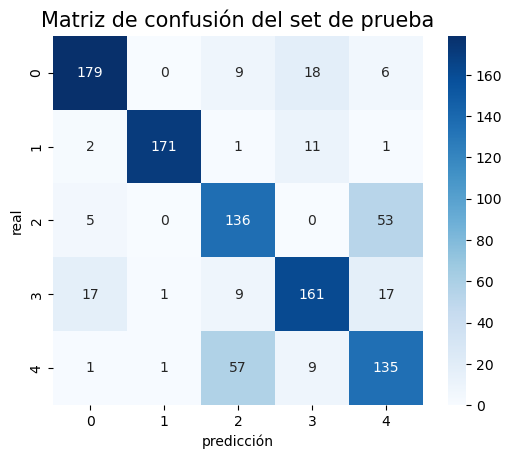

In [18]:
#confusion matrix
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt="d", cmap='Blues', square=True)
plt.title('Matriz de confusión del set de prueba', fontsize = 15)
plt.xlabel("predicción")
plt.ylabel("real")
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> 

Análisis del ejercicio:

   - Comentar los resultados de la búsqueda del mejor hiperparámetro.
   - ¿Cómo se visualiza gráficamente el cambio del valor `n_neighbors`? ¿Tiene sentido esta diferencia entre los dos gráficos al cambiar el parámetro?
   - ¿Cómo son las fronteras de decisión? ¿Tiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¿Cómo son las predicciones obtenidas sobre el conjunto de test?
</div>

- Al utilizar el método GridSearchCV obtuvimos que el mejor hiperparámetro 'n_neighbors' para esta muestra de datos es 9.  
    En el heatmap podemos ver los resultados de la métrica 'accuracy' para el modelo probando con valores del 1 al 10 para el hiperparámetro 'n_neighbors', y para cada una de las cuatro particiones estratificadas. Vemos que los valores más altos ocurren con n_neighbors=9. 
    Por otro lado, en el dataframe creado: knn_df, además de la información del accuracy para cada partición y cada opción del hiperparámetro, tenemos el valor medio para cada n_neighbors, donde podemos comprobar que el valor medio de accuracy más alto ocurre con n_neighbors = 9.

- Al cambiar de n_neighbors 2 a 9 lo que le estamos indicando al algoritmo es que para clasificar un punto tome sólo los dos vecinos más  cercanos o tome los 9 vecinos más cercanos a ese punto. A nivel gráfico lo que vemos es que se suavizan o se hacen más homogeneos los grupos que pertenecen a cada target, al seleccionar sólo dos vecinos vemos que dentro de los grupos grandes aparecen grupitos pequeños de otro color, es decir de otro target, esto ocurre porque sólo está tomando los dos vecinos más  cercanos, en cambio, al agrandar el espacio y elegir los 9 vecinos más cercanos es más probable que para el conjunto de datos cercanos se clasifique con el mismo target, que es lo que vemos en el segundo gráfico. 
    
- Las fronteras de decisión no son suaves como en el caso del clasificador Naives Bayes, en este caso no se utiliza un función de probabilidad sino que para cada punto se buscan sus n vecinos más cercanos y se le asigna la clase mayoritaria entre esos n vecinos, por eso vemos cortes en la frontera de decisión. 
    
- En cuanto a las predicciones, vemos que al igual que el clasificar Naive Bayes, el target que mejor accuracy tuvo es el 2 que corresponde a Trouser,lo cual es esperable porque es la clase que más separada está del resto, la de color verde en el gráfico. El accuracy total del modelo es de 0,78 el cual está por encima del obtenido en el modelo anterior de 0,72.

### 1.3. SVM

Las Support Vector Machine (SVM) se fundamentan en el _Maximal Margin Classifier_, que a su vez, se basan en el concepto de hiperplano.

En un espacio p-dimensional, un hiperplano se define como un subespacio plano y afín de dimensiones p-1. El término afín significa que el subespacio no debe pasar por el origen. En un espacio de dos dimensiones, el hiperplano es un subespacio de 1 dimensión, es decir, una recta. En un espacio tridimensional, un hiperplano es un subespacio de dos dimensiones, un plano convencional. Para dimensiones p>3 no es intuitivo visualizar un hiperplano, pero el concepto de subespacio con p-1 dimensiones se mantiene.

La definición de hiperplano para casos perfectamente separables linealmente resulta en un número infinito de posibles hiperplanos, lo que hace necesario un método que permita seleccionar uno de ellos como clasificador óptimo.

La solución a este problema consiste en seleccionar como clasificador óptimo al que se conoce como _maximal margin hyperplane_ o hiperplano óptimo de separación, que se corresponde con el hiperplano que se encuentra más alejado de todas las observaciones de entrenamiento. Para obtenerlo, se debe calcular la distancia perpendicular de cada observación a un determinado hiperplano. La menor de estas distancias (conocida como margen) determina cómo de lejos está el hiperplano de las observaciones de entrenamiento. El _maximal margin hyperplane_ se define como el hiperplano que consigue un mayor margen, es decir, que la distancia mínima entre el hiperplano y las observaciones es lo más grande posible. Aunque esta idea suena razonable, no es posible aplicarla, ya que habría infinitos hiperplanos contra los que medir las distancias. En su lugar, se recurre a métodos de optimización.

El proceso de optimización tiene la peculiaridad de que sólo las observaciones que se encuentran justo al margen o que lo violan influyen sobre el hiperplano. A estas observaciones se les conoce como vectores soporte (_vectors suport_) y son las que definen el clasificador obtenido.

#### Los _kernels_ en SVM

Hay veces en que no hay manera de encontrar un hiperplano que permita separar dos clases. En estos casos decimos que las clases no son linealmente separables. Para resolver este problema podemos utilizar el truco del núcleo .

El truco del núcleo (_kernel trick_) consiste en utilizar una dimensión nueva en la que podamos encontrar un hiperplano para separar las clases. Se puede ver un un ejemplo en: https://www.youtube.com/watch?v=OdlNM96sHio

Al igual que en el algoritmo visto anteriormente (KNN), las SVM también dependen de varios hiperparámetros. 

En este caso intentaremos optimizar dos hiperparámetros:

  - **C**: es la regularización, es decir, el valor de penalización de los errores en la clasificación. Indica el compromiso entre obtener el hiperplano con el margen más grande posible y clasificar el máximo número de ejemplos correctamente. Probaremos los valores: 0.01, 0.1, 1, 10, 50, 100 y 200.
  
  - **Gama**: coeficiente que multiplica la distancia entre dos puntos en el kernel radial. Para decirlo a "grosso modo", cuanto más pequeño es gama, más influencia tienen dos puntos cercanos. Probaremos los valores: 0.001, 0.01, 0.1, 1 y 10.
  
Al igual que en el caso anterior, para validar el rendimiento del algoritmo con cada combinación de hiperparámetros utilizaremos validación cruzada (_cross-validation_) con 4 particiones estratificadas.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> 

Cálcular del valor óptimo de los hiperparámetros _C_ y _gama_. Utilizad una búsqueda de rejilla con validación cruzada para encontrar los valores óptimos. Para cada combinación de valores, calcular su promedio y la desviación estándar. Haced un _heatmap_ para visualizar la precisión según los diferentes valores de los hiperparámetros.

Podéis utilizar el módulo `GridSearchCV` de `sklearn` el cálculo de los mejores hiperparámetros con el clasificador SVC (de `SVM` de `sklearn`), y `heatmap` de `Seaborn`.
</div>

In [19]:
# Grilla para Grid Search
param_grid = {'C': [0.01, 0.1, 1, 10, 50, 100, 200], 
              'gamma': [0.001, 0.01, 0.1, 1, 10]
             } 
#Modelo a usar:
svm_clf = SVC()

model = GridSearchCV(svm_clf, param_grid, cv=4, scoring='accuracy')
model.fit(X_train_projection, y_train)
y_pred = model.predict(X_test_projection)

In [20]:
# Mejor estimador
print(model.best_estimator_)

SVC(C=1, gamma=10)


Tabla con el valor de accuracy para cada combinacion de hiperparámetros C y gamma, y para cada una de las cuatro particiones, con el valor medio y desviación estándar para cada una de las combinaciones C/gamma

In [21]:
results = []
results.append(model.cv_results_['split0_test_score'])
results.append(model.cv_results_['split1_test_score'])
results.append(model.cv_results_['split2_test_score'])
results.append(model.cv_results_['split3_test_score'])
results.append(model.cv_results_['mean_test_score'])
results.append(model.cv_results_['std_test_score'])
results = np.asmatrix(results)
results

# creating a list of index names
index_values = ['Accuracy cv=1', 'Accuracy cv=2', 'Accuracy cv=3','Accuracy cv=4','Mean Accuracy','Standard Deviation']
     
# creating a list of column names
a_list = np.arange(0,35)
column_values = [str(model.cv_results_['params'][x]).replace('{' ,'').replace('}' ,'') for x in a_list]



# creating the dataframe
svm_df = pd.DataFrame(data = results, 
                  index = index_values, 
                  columns = column_values)
svm_df.T

,Accuracy cv=1,Accuracy cv=2,Accuracy cv=3,Accuracy cv=4,Mean Accuracy,Standard Deviation
"'C': 0.01, 'gamma': 0.001",0.394,0.395,0.394,0.398,0.39525,0.001639
"'C': 0.01, 'gamma': 0.01",0.704,0.730,0.714,0.714,0.71550,0.009314
"'C': 0.01, 'gamma': 0.1",0.742,0.756,0.735,0.752,0.74625,0.008258
"'C': 0.01, 'gamma': 1",0.761,0.763,0.739,0.774,0.75925,0.012696
"'C': 0.01, 'gamma': 10",0.203,0.203,0.204,0.204,0.20350,0.000500
"'C': 0.1, 'gamma': 0.001",0.710,0.733,0.714,0.718,0.71875,0.008700
"'C': 0.1, 'gamma': 0.01",0.754,0.767,0.749,0.766,0.75900,0.007714
"'C': 0.1, 'gamma': 0.1",0.751,0.773,0.757,0.778,0.76475,0.011099
"'C': 0.1, 'gamma': 1",0.773,0.797,0.787,0.804,0.79025,0.011648
"'C': 0.1, 'gamma': 10",0.789,0.813,0.810,0.817,0.80725,0.010825


Buscamos la combinación de hiperparámetros que de el accuracy mas alto: 

In [22]:
svm_df.T[svm_df.T['Mean Accuracy'] == svm_df.T['Mean Accuracy'].max()]

,Accuracy cv=1,Accuracy cv=2,Accuracy cv=3,Accuracy cv=4,Mean Accuracy,Standard Deviation
"'C': 1, 'gamma': 10",0.803,0.819,0.806,0.82,0.812,0.007583


Corresponde al mejor estimador que encontró el método GridSearchCV: C=1 y gamma=10

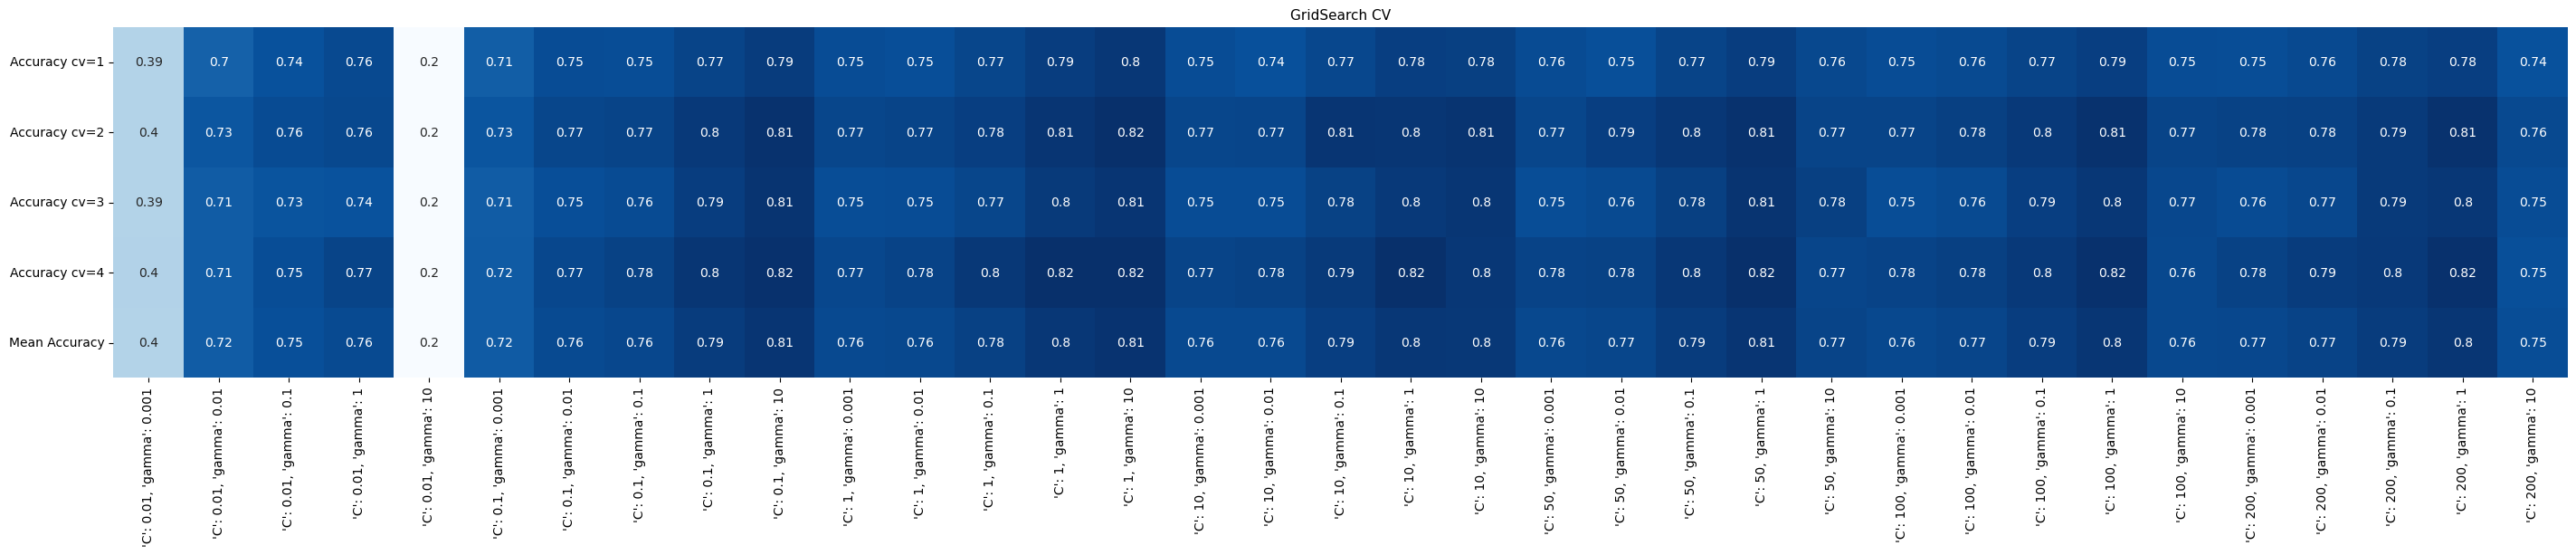

In [23]:
#HEATMAP CON LA PRECISION DEL MODELO PARA CADA HIPERPARAMETRO C Y GAMMA TESTEADO:
m = svm_df
m = m.drop(['Standard Deviation'], axis=0)
#Matrix
plt.figure(figsize=(35,25))
sns.heatmap(m, annot=True, cmap='Blues', square=True, cbar=False)
plt.title('GridSearch CV', fontsize = 11)
plt.show()

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Con la mejor combinación de hiperparámetros encontrada, entrenad un clasificador `SVM` (con _train_) y representar las fronteras de decisión con los puntos de _test_.
    
Calcular el _accuracy_ del modelo obtenido sobre _test_ y la matriz de confusión. Puede utilizar `accuracy_score` y `confusion_matrix` de `metrics` de `sklearn`.
</div>

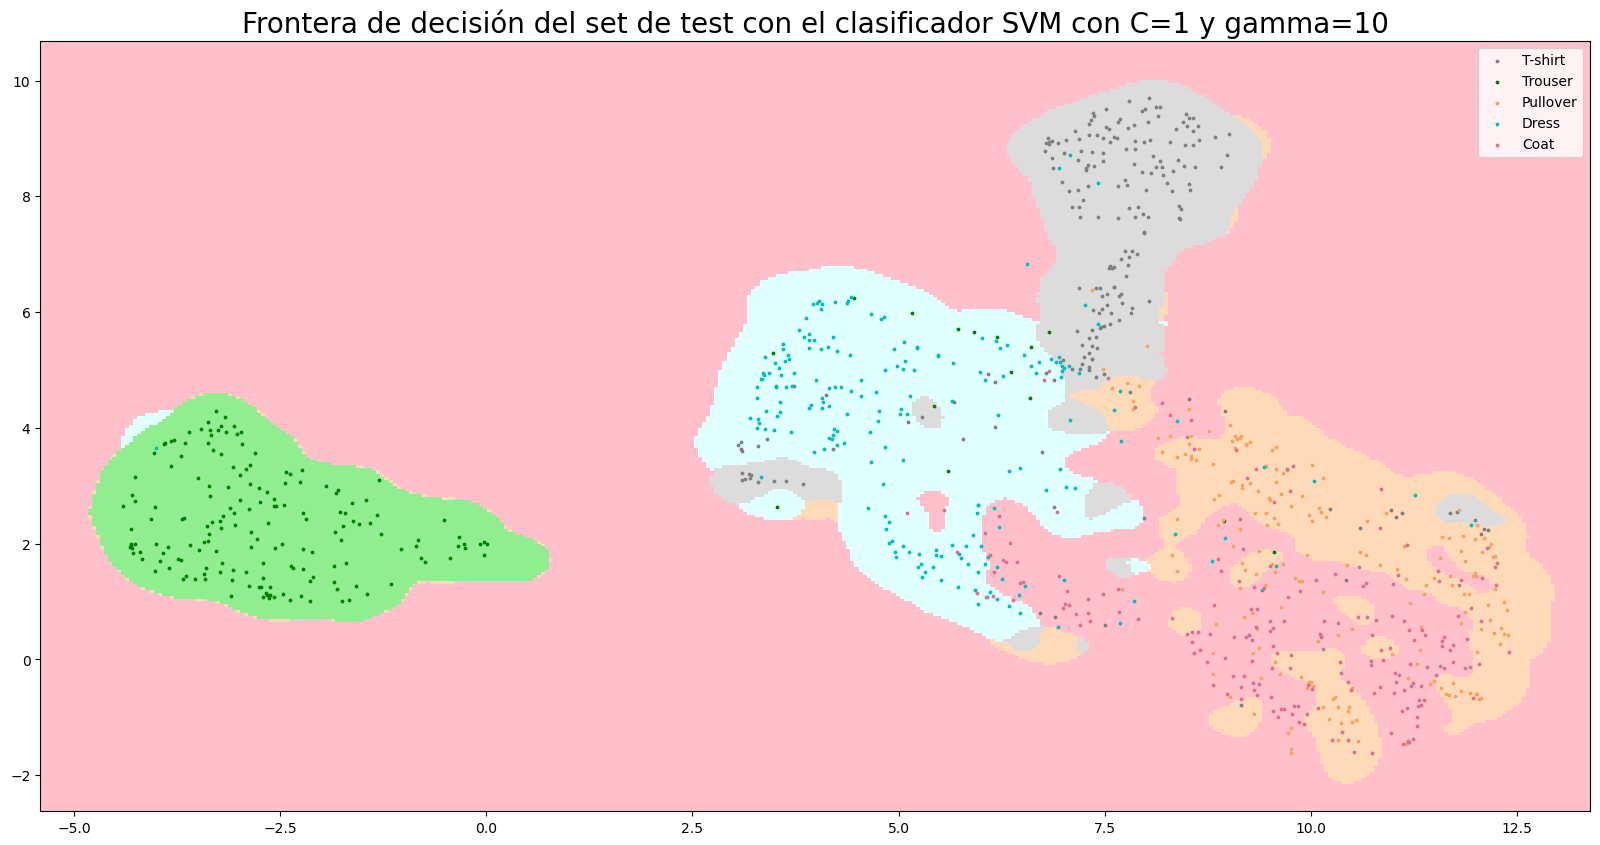

In [24]:
clfSVM = SVC(C=1, gamma=10)
clfSVM.fit(X_train_projection, y_train)

#Predecimos los labels del conjunto de testeo:
y_pred = clfSVM.predict(X_test_projection)

#Grafico de la frontera de decision:
plot_decision_boundaries(clfSVM,X_test_projection, y_test)
plt.title('Frontera de decisión del set de test con el clasificador SVM con C=1 y gamma=10', fontsize = 20)
plt.show()

In [25]:
print('Model accuracy score: {0:0.2f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score: 0.79


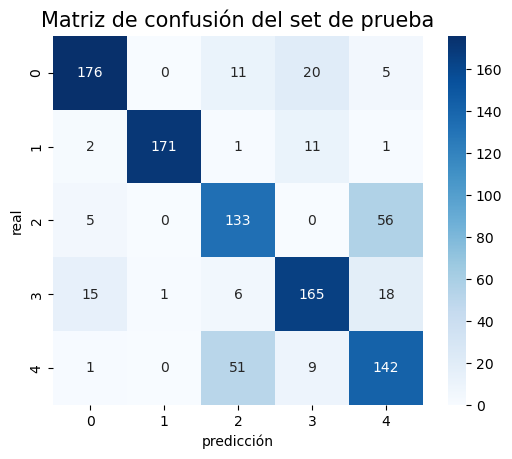

In [26]:
#confusion matrix
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt="d", cmap='Blues', square=True)
plt.title('Matriz de confusión del set de prueba', fontsize = 15)
plt.xlabel("predicción")
plt.ylabel("real")
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

Análisis del ejercicio.

   - Comentar los resultados de la búsqueda de los mejores hiperparámetros.
   - ¿Cómo son las fronteras de decisión? ¿Tiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¿Cómo son las predicciones obtenidas sobre el conjunto de test?
</div>

-  El mejor estimados calculado por GridSearchCV fue con C=1 y gamma=10. En el heatmap podemos ver los resultados de la métrica 'accuracy' para el modelo probando con varios valores para el hiperparámetro 'C' y 'gamma', y para cada una de las cuatro particiones estratificadas. Vemos que hay varias combinaciones que dan un valor medio de accuracy de 0.8, pero la combinación que tiene el valor de accuracy más alto para cada una de las cuatro particiones es C=1 y gamma=10. En el dataframe creado con estos datos, svm_df, al seleccionar la fila con el mayor valor medio de accuracy nos devuelve efectivamente la misma que el método GridSearchCV. 
- Las fronteras de decisión tienen una forma suave no lineal por el uso del kernel Gaussiano o radial ('rbf'), cuya fórmula exponencial hace que al calcular la distancia entre un puntos y los demás, si son puntos cercanos y por lo tanto la distancia es cercana a cero, la exponencial de un valor cercano a cero, se acerca a uno, es decir se forma una campana de Gauss con valores altos en la zona de similitud y valores bajos en las zonas de no similitud, esto genera las formas redondeadas que se ven en la frontera de decisión.
- El accuracy del modelo es 0.79, hasta ahora el valor más alto. En cuanto a las predicciones seguimos viendo que la clase mejor clasificada es 'Trouser' y las que más se confunden entre ellas son 'Pullover' Y 'Coat' por la similitud de su forma que se ve en los pixeles que las representan.


### 1.4. Árboles de decisión

Los árboles de decisión son modelos predictivos formados por reglas binarias (si / no) con las que se consigue repartir las observaciones en función de sus atributos y predecir así el valor de la variable respuesta.

Los árboles pueden ser **clasificadores** (para clasificar clases, tales como nuestro ejemplo), o bien **regresores** (para predecir variables continuas).

#### Construcción de un árbol

La creación de las ramificaciones de los árboles se logra mediante el algoritmo de *recursive binary splitting*. Este algoritmo consta de tres pasos principales:

   - El proceso se inicia en lo alto del árbol, donde todas las observaciones pertenecen a la misma región.
   - Se identifican todos los posibles puntos de corte para cada uno de los predictores. Los puntos de corte son cada uno de sus niveles.
   - se evalúan las posibles divisiones de cada predictor de acuerdo a una determinada medida. En el caso de los clasificadores se utilizan: *classification error rate*, Gini, entropía, chi-square.

#### Evitando el *overfitting*

El proceso de construcción de árboles descrito tiende a reducir rápidamente el error de entrenamiento, por lo que generalmente el modelo se ajusta muy bien a las observaciones utilizadas como entrenamiento (conjunto de *train*). Como consecuencia, los árboles de decisión tienden al *overfitting*. 

Para prevenirlo, utilizaremos dos hiperparámetros:

   - `max_depth`: la profundidad máxima del árbol. Exploraremos los valores entre 4 y 10.
   - `min_samples_split`: el número mínimo de observaciones que debe tener una hoja del árbol para poder dividir. Exploraremos los valores: 2, 10, 20, 50 y 100.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong>

Calculad el valor óptimo de los hiperparámetros `max_depth` y `min_samples_split`. Utilizad una búsqueda de rejilla con validación cruzada para encontrar los valores óptimos. Para cada combinación de valores, calcular su promedio y la desviación estándar. Haced un _heatmap_ para visualizar la precisión según los diferentes valores de los hiperparámetros.
    
Pódeis utilizar el módulo `GridSearchCV` de `sklearn` el cálculo de los mejores hiperparámetros con el clasificador `DecisionTreeClassifier` (de `tree` de `sklearn`), y `heatmap` de `Seaborn`.
</div>

In [27]:
# Grilla para Grid Search
param_grid = {'max_depth' : [4,5,6,7,8,9,10], 
              'min_samples_split': [2,10,20,50,100]
             } 
#Modelo a usar:
tree_clf = DecisionTreeClassifier()

model = GridSearchCV(tree_clf, param_grid, cv=4, scoring='accuracy')
model.fit(X_train_projection, y_train)
y_pred = model.predict(X_test_projection)

In [28]:
# Mejor estimador
print(model.best_estimator_)

DecisionTreeClassifier(max_depth=7, min_samples_split=100)


Tabla con el valor de accuracy para cada combinacion de hiperparámetros max_depth y min_samples_split, y para cada una de las cuatro particiones, con el valor medio y desviación estándar:

In [29]:
results = []
results.append(model.cv_results_['split0_test_score'])
results.append(model.cv_results_['split1_test_score'])
results.append(model.cv_results_['split2_test_score'])
results.append(model.cv_results_['split3_test_score'])
results.append(model.cv_results_['mean_test_score'])
results.append(model.cv_results_['std_test_score'])
results = np.asmatrix(results)
results

# creating a list of index names
index_values = ['Accuracy cv=1', 'Accuracy cv=2', 'Accuracy cv=3','Accuracy cv=4','Mean Accuracy','Standard Deviation']
     
# creating a list of column names
a_list = np.arange(0,35)
column_values = [str(model.cv_results_['params'][x]).replace('{' ,'').replace('}' ,'') for x in a_list]



# creating the dataframe
tree_df = pd.DataFrame(data = results, 
                  index = index_values, 
                  columns = column_values)
tree_df.T

,Accuracy cv=1,Accuracy cv=2,Accuracy cv=3,Accuracy cv=4,Mean Accuracy,Standard Deviation
"'max_depth': 4, 'min_samples_split': 2",0.750,0.774,0.762,0.775,0.76525,0.010183
"'max_depth': 4, 'min_samples_split': 10",0.750,0.774,0.762,0.775,0.76525,0.010183
"'max_depth': 4, 'min_samples_split': 20",0.750,0.774,0.762,0.775,0.76525,0.010183
"'max_depth': 4, 'min_samples_split': 50",0.750,0.774,0.762,0.775,0.76525,0.010183
"'max_depth': 4, 'min_samples_split': 100",0.750,0.774,0.762,0.775,0.76525,0.010183
"'max_depth': 5, 'min_samples_split': 2",0.779,0.780,0.762,0.799,0.78000,0.013096
"'max_depth': 5, 'min_samples_split': 10",0.779,0.780,0.762,0.799,0.78000,0.013096
"'max_depth': 5, 'min_samples_split': 20",0.779,0.780,0.762,0.799,0.78000,0.013096
"'max_depth': 5, 'min_samples_split': 50",0.779,0.781,0.762,0.799,0.78025,0.013103
"'max_depth': 5, 'min_samples_split': 100",0.779,0.781,0.765,0.802,0.78175,0.013217


Buscamos la combinación de hiperparámetros que de el accuracy mas alto: 

In [30]:
tree_df.T[tree_df.T['Mean Accuracy'] == tree_df.T['Mean Accuracy'].max()]

,Accuracy cv=1,Accuracy cv=2,Accuracy cv=3,Accuracy cv=4,Mean Accuracy,Standard Deviation
"'max_depth': 7, 'min_samples_split': 100",0.783,0.8,0.767,0.804,0.7885,0.014705


Coincide con el resultado del GridSearchCV, el modelo con el mejor accuracy es el que tiene max_depth = 7 y min_sample_split = 100

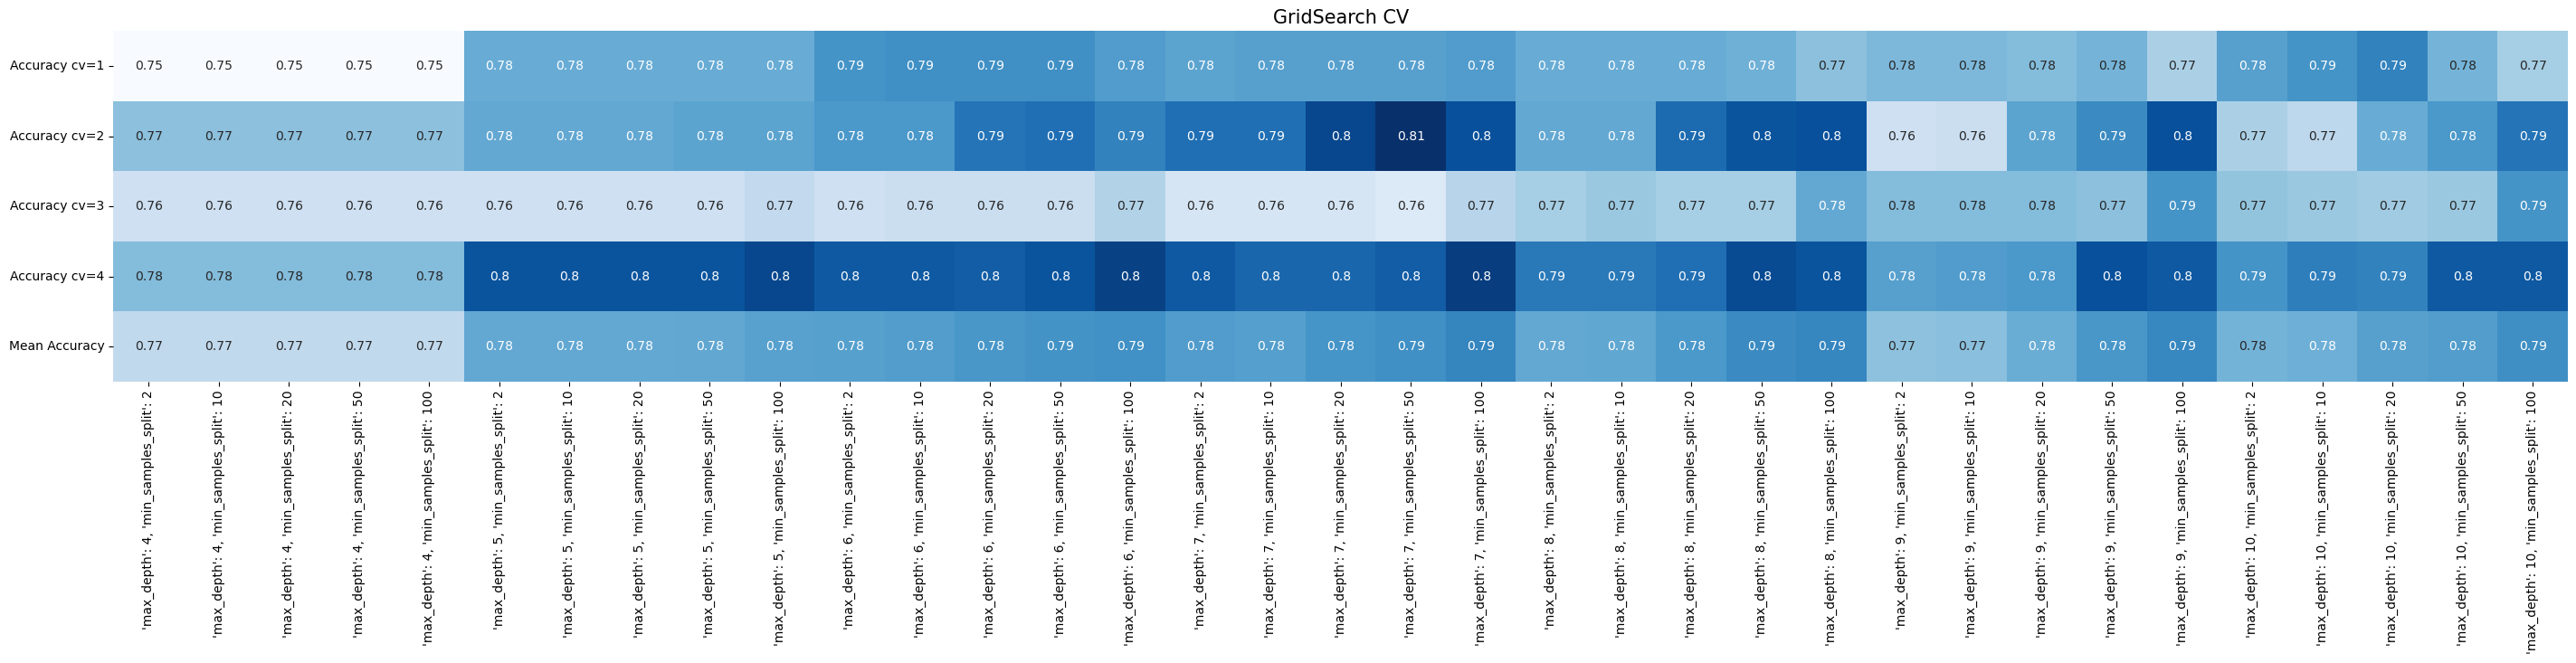

In [31]:
#HEATMAP CON LA PRECISION DEL MODELO PARA CADA HIPERPARAMETRO C Y GAMMA TESTEADO:
m = tree_df
m = m.drop(['Standard Deviation'], axis=0)
#Matrix
plt.figure(figsize=(35,25))
sns.heatmap(m, annot=True, cmap='Blues', square=True, cbar=False)
plt.title('GridSearch CV', fontsize = 15)
plt.show()

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Con la mejor combinación de hiperparámetros encontrados, entrenad un clasificador `DecisionTreeClassifier` (con `train`) y representar las fronteras de decisión con los puntos de `test`.
    
Calcular el _accuracy_ del modelo obtenido sobre _test_ y la matriz de confusión. Puede utilizar `accuracy_score` y `confusion_matrix` de `metrics` de `sklearn`.
</div>

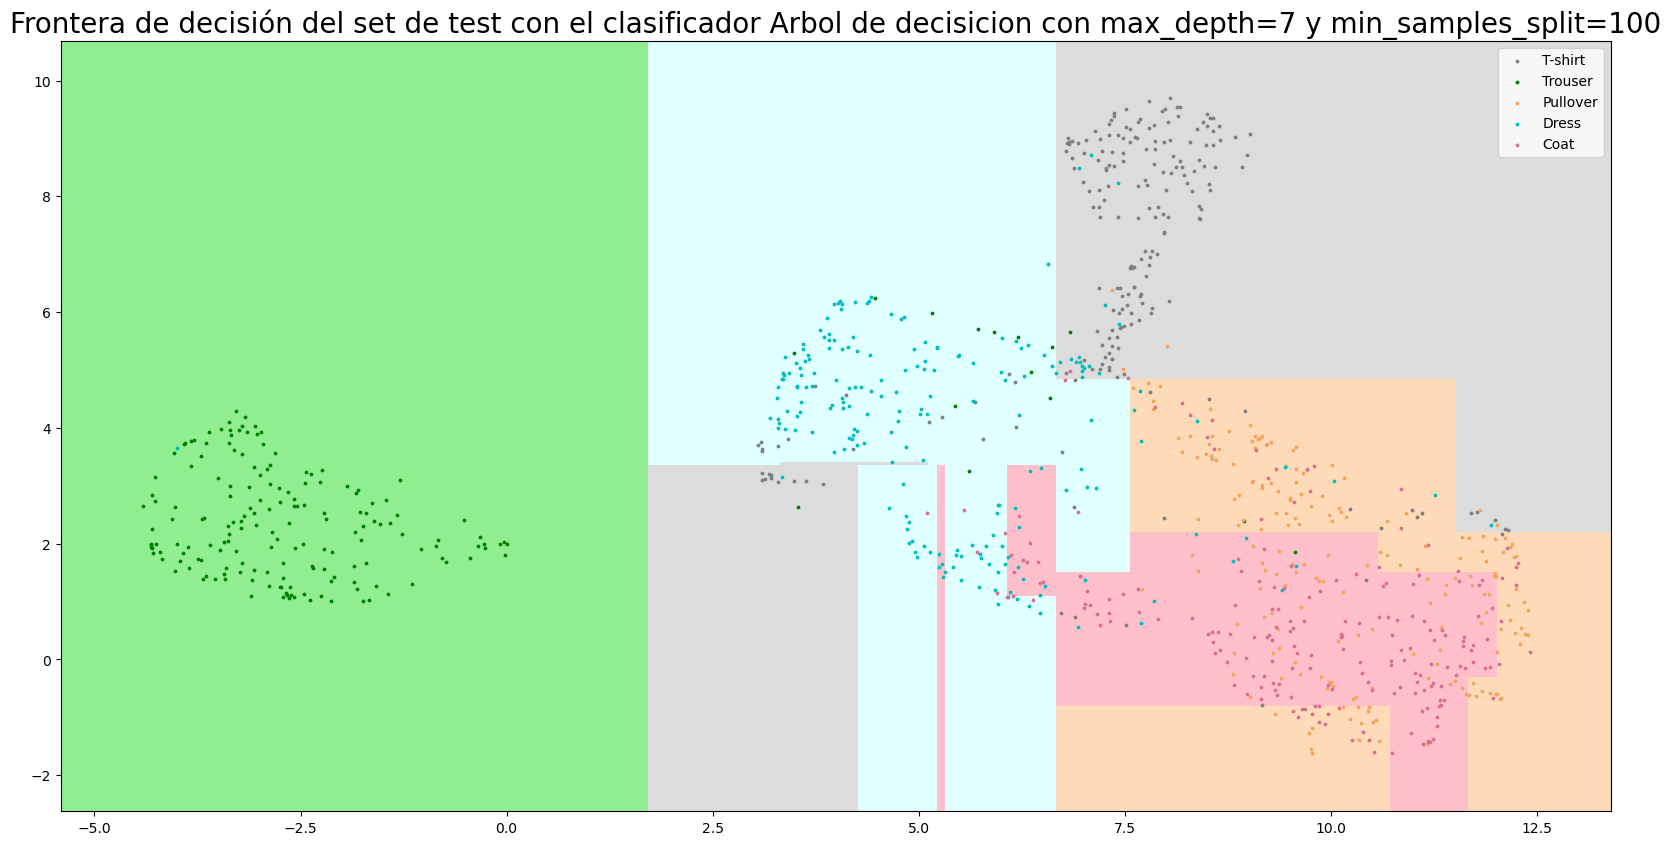

In [32]:
clfTree = DecisionTreeClassifier(max_depth = 7, min_samples_split = 100)
clfTree.fit(X_train_projection, y_train)

#Predecimos los labels del conjunto de testeo:
y_pred = clfTree.predict(X_test_projection)

#Grafico de la frontera de decision:
plot_decision_boundaries(clfTree,X_test_projection, y_test)
plt.title('Frontera de decisión del set de test con el clasificador Arbol de decisicion con max_depth=7 y min_samples_split=100', fontsize = 20)
plt.show()

In [33]:
print('Model accuracy score: {0:0.2f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score: 0.78


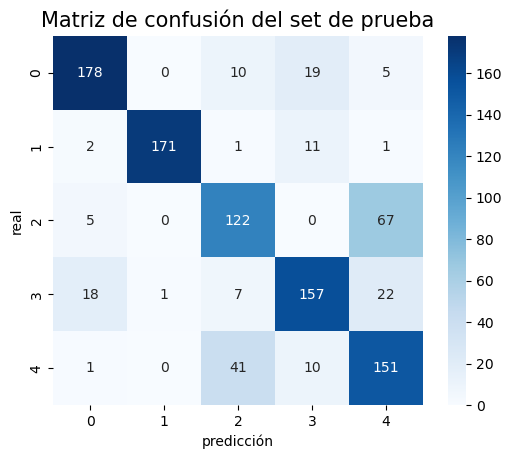

In [34]:
#confusion matrix
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt="d", cmap='Blues', square=True)
plt.title('Matriz de confusión del set de prueba', fontsize = 15)
plt.xlabel("predicción")
plt.ylabel("real")
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

Análisis del ejercicio.

   - Comentar los resultados de la búsqueda de los mejores hiperparámetros.
   - ¿Cómo son las fronteras de decisión? ¿Tiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¿Cómo son las predicciones obtenidas sobre el conjunto de test?
</div>

- El mejor estimados calculado por GridSearchCV fue con max_depth=7 y min_samples_split=100. En el heatmap podemos ver los resultados de la métrica 'accuracy' para el modelo probando con varios valores para el hiperparámetro 'max_depth' y 'min_samples_split', y para cada una de las cuatro particiones estratificadas. Vemos que hay varias combinaciones que dan un valor medio de accuracy de 0.79, pero la combinación que tiene el valor de accuracy más alto para cada una de las cuatro particiones es max_depth=7 y min_samples_split=100. En el dataframe creado con estos datos, tree_df, al seleccionar la fila con el mayor valor medio de accuracy nos devuelve efectivamente la misma que el método GridSearchCV. 
- Las fronteras de decisión que obtuvimos en este caso son cuadradas porque el modelo va generando la frontera a partir de separar los datos haciendo preguntas con un umbral, los datos que cumplen con la condición del umbral van hacia un grupo y los datos que no van al otro, luego cada uno de estos grupos se convierten en un nodo y se vuelve a hacer una pregunta (esto sigue hasta llegar al max_depth o hasta que en cada grupo todos las observaciones sean de la misma clase).
- En este caso obtuvimos un accuracy de 0.78, igual al valor obtenido con el clasificador KNN. En cuanto a las predicciones también lo hizo muy bien clasificando la clase 'Trouser' y tuvo problemas intercambiando la clase 'Coat' y 'Pullover'.

### 1.5. Mejorando los árboles de decisión

En la práctica, casi nunca se utiliza un solo árbol de decisión, sino que se combinan muchos árboles para obtener mejores resultados. Hay dos maneras de combinar árboles:

  - *__Bagging__*: utilizar el conjunto de entrenamiento original para generar centenar o miles de conjuntos similares utilizando muestreo con reemplazo. El algoritmo _random forest_ está basado en este concepto, la combinación de varios árboles de decisión, cada uno entrenado con una muestra diferente de los datos. La decisión final del clasificador combinado (la _random forest_) se toma por mayoría, dando el mismo peso a todas las decisiones parciales tomadas por los clasificadores base (los árboles).
  
  - *__Boosting__*: se combinan varios clasificadores débiles secuencialmente, y en cada uno de ellos se da más peso a los datos que han sido erróneamente clasificadas en las combinaciones anteriores, para que se concentre así en los casos más difíciles de resolver.
  
Ambos métodos los estudiaremos más en detalle en la próxima PEC, pero en esta haremos un vistazo a los beneficios que nos aporta utilizar combinaciones de árboles respecto un solo árbol.

Al tratarse de árboles, sigue siendo importante optimizar `max_depth` y `min_samples_split`, pero en este caso añadiremos un hiperparámetro más. Para simplificar, de los dos parámetros anteriores optimizaremos sólo `max_depth`:

  - `n_estimators`: número de árboles. Exploraremos los valores: 50, 100 y 200.
  - `max_depth`: la profundidad máxima del árbol. Exploraremos los valores entre 8 y 12.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong>

Escoged uno de los dos algoritmos mencionados: RandomForestClassifier o GradientBoostingClassifier. Calculad el valor óptimo de los hiperparámetros `n_estimators` y `max_depth`. Utilizad una búsqueda de rejilla con validación cruzada para encontrar los valores óptimos. Para cada combinación de valores, calcular su promedio y la desviación estándar. Haced un _heatmap_ para visualizar la precisión según los diferentes valores de los hiperparámetros.
    
Podéis utilizar el módulo `GridSearchCV` de `sklearn` para el cálculo de los mejores hiperparámetros con el clasificador `RandomForestClassifier` o `GradientBoostingClassifier` (de `ensemble` de `sklearn`), y `heatmap` de `Seaborn`.
    
<u>Nota</u>: al utilizar tantos árboles, el _cross validation_ con todas las combinaciones de parámetros es más costosa que en los ejemplos anteriores, y por lo tanto tardará más en ejecutarse.
</div>

In [35]:
# Grilla para Grid Search
param_grid = {'max_depth' : [8,9,10,11,12], 
              'n_estimators': [50,100,200]
             } 
#Modelo a usar:
forest_clf = RandomForestClassifier()

model = GridSearchCV(forest_clf, param_grid, cv=4, scoring='accuracy')
model.fit(X_train_projection, y_train)
y_pred = model.predict(X_test_projection)

In [36]:
# Mejor estimador
print(model.best_estimator_)

RandomForestClassifier(max_depth=10, n_estimators=200)


<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Con la mejor combinación de hiperparámetros encontrada, entrenad un clasificador con el modelo elegido (con _train_) y representar las fronteras de decisión con los puntos de test.
    
Calcular el _accuracy_ del modelo obtenido sobre test y la matriz de confusión. Puede utilizar `accuracy_score` y `confusion_matrix` de `metrics` de `sklearn`.
</div>

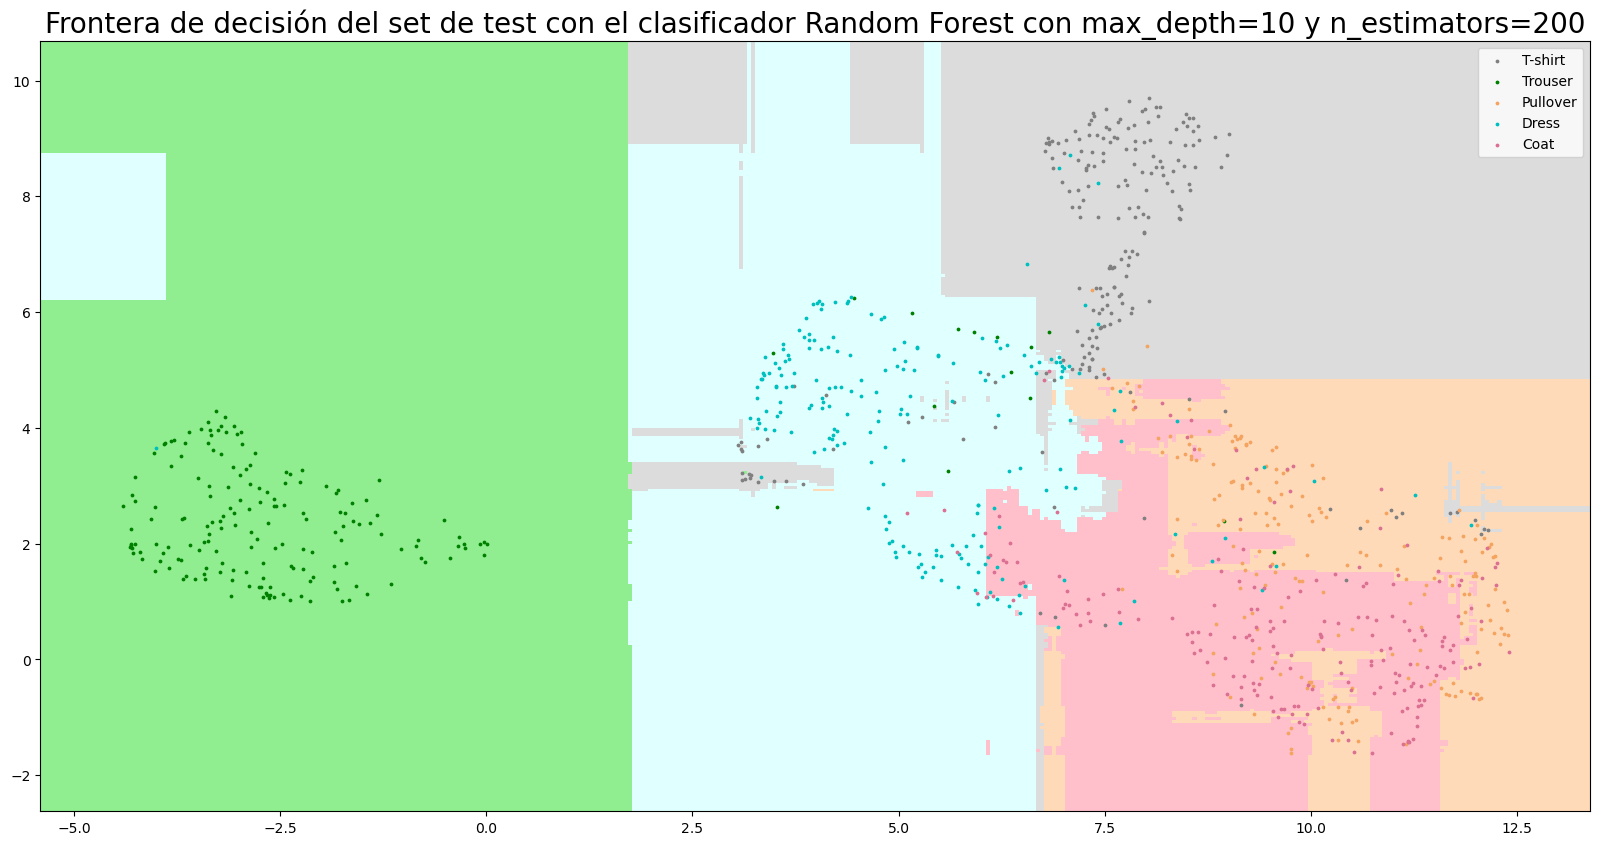

In [37]:
forest_clf = RandomForestClassifier(max_depth = 10, n_estimators = 200)
forest_clf.fit(X_train_projection, y_train)

#Predecimos los labels del conjunto de testeo:
y_pred = forest_clf.predict(X_test_projection)

#Grafico de la frontera de decision:
plot_decision_boundaries(forest_clf,X_test_projection, y_test)
plt.title('Frontera de decisión del set de test con el clasificador Random Forest con max_depth=10 y n_estimators=200', fontsize = 20)
plt.show()

In [38]:
print('Model accuracy score: {0:0.2f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score: 0.79


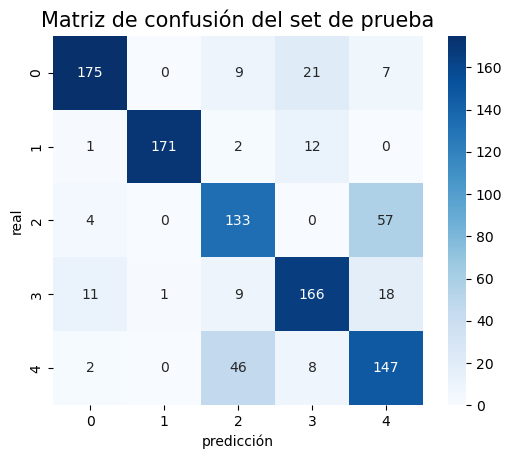

In [39]:
#confusion matrix
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt="d", cmap='Blues', square=True)
plt.title('Matriz de confusión del set de prueba', fontsize = 15)
plt.xlabel("predicción")
plt.ylabel("real")
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

Análisis del ejercicio.

   - Comentar los resultados de la búsqueda de los mejores hiperparámetros.
   - ¿Cómo son las fronteras de decisión? ¿Tiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¿Cómo son las predicciones obtenidas sobre el conjunto de test?
   - ¿Ha habido mejora respecto a utilizar un simple árbol de decisión?
</div>

- El mejor estimados calculado por GridSearchCV fue con max_depth=10 y n_estimators=200, es decir será un Random Forest de 200 árboles, cada uno de los cuales puede tener una profundidad máxima (nodos) de 10. 
- La frontera de decisión es similar a la que obtuvimos utilizando el árbol de decisión anterior, ya que lo que hace el Random Forest es clasificar cada observación de la misma forma que lo hace un árbol de decisición pero comparando el resultado de varios árboles, es decir que este modelo genera de forma paralela 200 árboles de decisión (cada uno de los cuales es alimentado con una muestra aleatoria tomada del dataset y un conjunto de atributos k también aleatorios), una vez que se crearon estos árboles se elige la salida que más votos tenga entre las 200 salidas, es decir la 'clase' que más árboles tengan en su salida, por esta razón la frontera de decisión tiene forma similar al caso anterior, porque también se basa en preguntas a respuestas con umbrales.
- En cuanto a las predicciones vemos que las clases 2 y 3 siguen siendo las que más cuesta clasificar bien
- Si, al utilizar el bosque que considera la salida de 200 árboles de decisión en lugar de uno sólo vemos que el accuracy del modelo subió a 0.79

<a id='ej2'></a>
### 2. Implementación del caso práctico

En este caso práctico, construiremos un modelo predictivo que detectará si el comentario escrito por un usuario de Amazon en una reseña sobre una aplicación para Android es bueno o no, utilizando exclusivamente el texto de dicho comentario como punto de partida. El problema que vamos a resolver en este apartado se engloba dentro del área de investigación conocida como [análisis de sentimiento (_sentiment analysis_)](https://es.wikipedia.org/wiki/An%C3%A1lisis_de_sentimiento) que utiliza, entre otras cosas, procesamiento de lenguaje natural, análisis de texto y lingüística computacional para identificar y extraer información subjetiva de distintos recursos.

El conjunto de datos con el que trabajaremos se ha obtenido de las valoraciones y comentarios dejados por un grupo de usuarios en las reseñas de diferentes productos de Amazon. En nuestro caso, nos centraremos en un subconjunto de 10000 reseñas de aplicaciones para Android con valoraciones desde 1 hasta 5 estrellas. El conjunto de datos original lo podéis encontrar en el siguiente enlace: http://jmcauley.ucsd.edu/data/amazon/

#### 2.0. Carga de datos

Lo primero que haremos será cargar el dato, que viene dentro de un fichero donde cada línea es una reseña en formato [JSON](https://es.wikipedia.org/wiki/JSON).

In [40]:
N_SAMPLES = 10000

review_list = []
with open("Apps_for_Android_5.json", "rt") as f:
    for i, line in enumerate(f):
        if i >= N_SAMPLES:
            break
        review_list.append(json.loads(line))

len(review_list)

10000

Como podemos ver en la siguiente celda, cada reseña se compone de, entre otras cosas, comentario (`'reviewText'`) y valoración (`'overall'`).

In [41]:
review_list[0]

{'reviewerID': 'A1N4O8VOJZTDVB',
 'asin': 'B004A9SDD8',
 'reviewerName': 'Annette Yancey',
 'helpful': [1, 1],
 'reviewText': "Loves the song, so he really couldn't wait to play this. A little less interesting for him so he doesn't play long, but he is almost 3 and likes to play the older games, but really cute for a younger child.",
 'overall': 3.0,
 'summary': 'Really cute',
 'unixReviewTime': 1383350400,
 'reviewTime': '11 2, 2013'}

#### 2.1. Preprocesamiento de los datos

Con el objetivo de aplicar algunos de los algoritmos vistos en el primer apartado de la PEC, procesaremos el conjunto de datos inicial para poder obtener desde el texto del comentario una serie de atributos descriptivos numéricos lo suficientemente representativos como para que al construir sobre ellos un clasificador obtengamos los resultados esperados.

El procesamiento del texto realizará los siguientes pasos:
- El texto se pasará por completo a letras minúsculas, minimizando la variedad de palabras resultante.
- Los números, direcciones de páginas web y de correo y el símbolo del dólar se substituirán por palabras especiales.
- Separación del texto en las palabras que posteriormente darán lugar a los futuros tokens.
- Eliminación de los caracteres no alfanuméricos que puedan quedar.
- Eliminación de [palabras vacías (_stopwords_)](https://es.wikipedia.org/wiki/Palabra_vac%C3%ADa) que no aportan información, tales como artículos o preoposiciones.
- Simplificación de las palabras quedándonos sólo con el lexema (raíz) de la misma, unificando en un solo token distintas palabras relacionadas semánticamente.

La siguiente funcion toma una reseña y devuelve una dupla formada por los tokens resultantes del procesado y si la valoración es buena o no, es decir, si su valoración es mayor que 3 o no.

In [42]:
def process_review(review):
    text = review['reviewText']
    # Pasamos el texto a minúsculas para minimizar la variedad de palabras.
    text = text.lower()
    # Reemplazamos los números por el token 'number'.
    text = re.sub('[0-9]+', 'number', text)
    # Cualquier cosa que comience con http o https:// es reemplazado por 'httpaddr'.
    text = re.sub('(http|https)://[^\s]*', 'httpaddr', text)
    # Cadenas de texto con "@" en su interior son consideradas direcciones de email: 'emailaddr'.
    text = re.sub('[^\s]+@[^\s]+', 'emailaddr', text)
    # El signo '$' es reemplazado por el token 'dollar'.
    text = re.sub('[$]+', 'dollar', text)
    # Separamos el comentario en palabras individuales o tokens.
    words = re.split('[ \@\$\/\#\.\-\:\&\*\+\=\[\]\?\!\(\)\{\}\,\'\"\>\_\<\;\%]', text)
    
    # Usaremos PorterStemmer para extraer las raíces de las palabras.
    stemmer = nltk.stem.porter.PorterStemmer()
    # Carreguem les "stopwords" angleses en un set perquè aquest és més eficient que una llista.
    stopwords = set(stopword.lower() for stopword in nltk.corpus.stopwords.words('english'))
    # 
    tokens = []
    for word in words:
        # Eliminamos todo aquello que no sean caracteres alfanuméricos.
        token = re.sub('[^a-zA-Z0-9]', '', word)
        # Tomamos únicamente sólo quellos los tokens que no estén vacíos ni pertenezcan al conjunto "stopwords"
        if token and word not in stopwords:
            # Extraemos la raíz de cada palabra.
            token = stemmer.stem(token)
            # Añadimos el token a la lista.
            tokens.append(token)
        
    # Devolvemos el token y si la reseña es buena o no (buena si la puntuación es mayor que 3).
    return tokens, review['overall'] > 3

In [43]:
process_review(review_list[0])

(['love',
  'song',
  'realli',
  'wait',
  'play',
  'littl',
  'less',
  'interest',
  'play',
  'long',
  'almost',
  'number',
  'like',
  'play',
  'older',
  'game',
  'realli',
  'cute',
  'younger',
  'child'],
 False)

Con ayuda de la función definida previamente, procesamos todas las reseñas:

In [44]:
tokens_list = []
y_list = []
for review in review_list:
    tokens, is_good = process_review(review)
    tokens_list.append(tokens)
    y_list.append(1 if is_good else 0)

In [45]:
tokens_list[0], y_list[0]

(['love',
  'song',
  'realli',
  'wait',
  'play',
  'littl',
  'less',
  'interest',
  'play',
  'long',
  'almost',
  'number',
  'like',
  'play',
  'older',
  'game',
  'realli',
  'cute',
  'younger',
  'child'],
 0)

In [46]:
y = np.array(y_list)

In [47]:
y

array([0, 1, 1, ..., 1, 1, 1])

En este punto, para cada reseña tenemos un valor binario que nos indica si es buena o no (variable objetivo) y una lista de tokens que puede o no tener elementos en común con las las listas de tokens de otras reseñas. Estas listas de tokens, tal y como están, aún no nos sirven a modo de atributos descriptivos para poder entrenar un modelo como los que hemos visto previamente.

Con el propósito de crear un número de variables igual y con el mismo significado para todas y cada una de las muestras, nos decidimos a elegir los tokens comunes en al menos el 1% de los comentarios para, posteriormente, realizar un conteo de veces que aparece cada uno de dichos tokens en cada reseña y generar, para cada reseña, un vector de variables numéricas en la que cada posición hace referencia a cada uno de esos tokens relevantes o comunes e indica cuántas veces aparece diccho token en el comentario en cuestión. A esta técnica se la conoce como bolsa de palabras (_bag of words_).

Sin embargo, antes de realizar este proceso, debemos dividir el conjunto de datos en los subconjuntos de entrenamiento y de test, ya que las palabras comunes las debemos decidir teniendo en cuenta sólo los datos de entrenamiento, puesto que cuando tengamos nuestro algoritmo en producción nos encontraremos con reseñas que no habremos tenido en cuenta para generar la mencionada lista de tokens comunes y debemos de estar preparados para ello simulándolo con el subconjunto de test.

Como última aclaración, es imporante, antes de dividir el dataset, conocer cómo es la distribución de las clases dentro del mismo, ya que si esta distribución no está equilibrada es necesario estratificar la división.

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> 

Estudia la distribución de valoraciones y de la clase (variable objetivo) "_es buena o no_".
    
</div>

In [48]:
bins = [1,2,3,4,5,6]

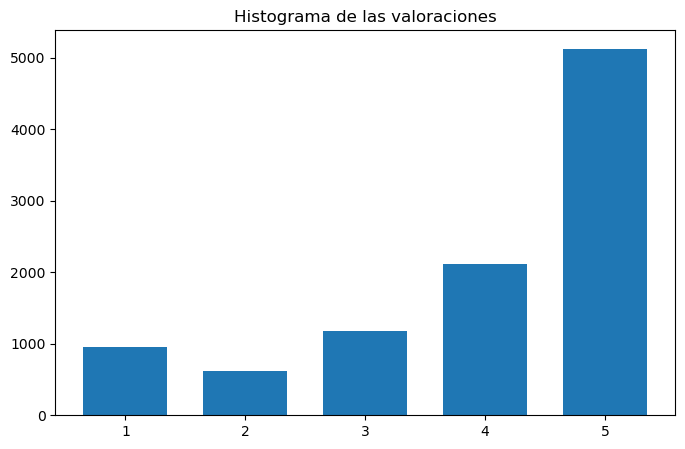

In [49]:
counts, bins = np.histogram([review_list[i]['overall'] for i in range(0,len(review_list))], bins=bins)
plt.figure(figsize=(8,5))
plt.hist(bins[:-1], bins = bins, weights=counts, rwidth=0.7, align='left')
plt.title('Histograma de las valoraciones')
plt.show()

In [50]:
all_reviews_list = list([review_list[i]['overall'] for i in range(0,len(review_list))])

In [51]:
total = len(all_reviews_list)
total_1 = all_reviews_list.count(1)
total_2 = all_reviews_list.count(2)
total_3 = all_reviews_list.count(3)
total_4 = all_reviews_list.count(4)
total_5 = all_reviews_list.count(5)

print('El ',(total_1/total)*100,'% corresponde a valoraciones=1')
print('El ',(total_2/total)*100,'% corresponde a valoraciones=2')
print('El ',(total_3/total)*100,'% corresponde a valoraciones=3')
print('El ',(total_4/total)*100,'% corresponde a valoraciones=4')
print('El ',(total_5/total)*100,'% corresponde a valoraciones=5')

El  9.5 % corresponde a valoraciones=1
El  6.23 % corresponde a valoraciones=2
El  11.85 % corresponde a valoraciones=3
El  21.13 % corresponde a valoraciones=4
El  51.29 % corresponde a valoraciones=5


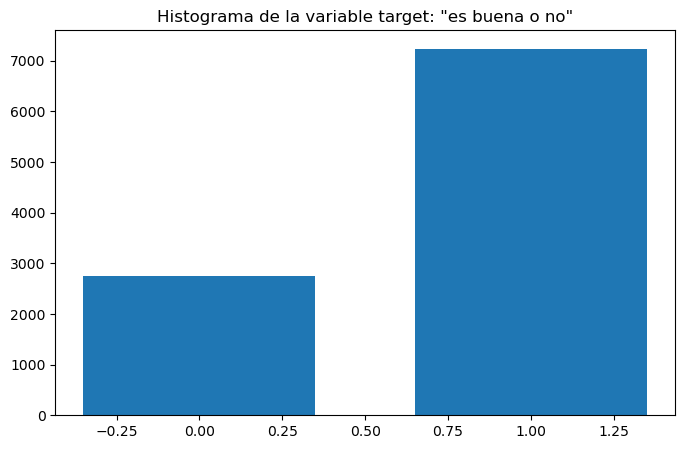

In [52]:
bins = [0,1,2]
counts, bins = np.histogram([y_list[i] for i in range(0,len(y_list))], bins=bins)
plt.figure(figsize=(8,5))
plt.hist(bins[:-1], bins = bins, weights=counts, rwidth=0.7, align='left')
plt.title('Histograma de la variable target: "es buena o no"')
plt.show()

In [53]:
total = len(y_list)
total_0 = y_list.count(0)
total_1 = y_list.count(1)

print('El ',(total_0/total)*100,'% corresponde a valoraciones buenas y el ',(total_1/total)*100,'% corresponde a valoraciones malas')

El  27.58 % corresponde a valoraciones buenas y el  72.42 % corresponde a valoraciones malas


<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Dividid el _dataset_ en dos subconjuntos, __*train*__ (80% de los datos) y __*test*__ (20% de los datos). Nombrad los conjuntos como: tokens_list_train, tokens_list_test, y_train, y_test. Utilizad la opción `random_state = 24`.
    
Podéis utilizar la implementación `train_test_split` de `sklearn`.

<u>Nota:</u> utilizad el parámetro `stratify` en caso de que sea necesario.
    
</div>

In [54]:
y = y
X = tokens_list

#Train and Test
tokens_list_train, tokens_list_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 24, stratify=y)

Es el momento de elegir una lista de los tokens representativos del conjunto de muestras de entrenamiento. Llamaremos a esta lista vocabulary.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Guarda en la variable __*vocabulary*__ la lista de tokens que aparecen al menos en un 1% de las reseñas de entrenamiento.
    
</div>

In [55]:
all_tokens = []

In [56]:
#Armo una lista con todos los tokens que aparecen en las 8000 reseñas:
for i in range(0,len(tokens_list_train)):
    for j in range(0,len(tokens_list_train[i])):
        all_tokens.append(tokens_list_train[i][j])

In [57]:
print('Hay ',len((all_tokens)),' tokens en total tomando las 8000 reseñas del conjunto train, de las cuales ',len(set(all_tokens)),'son los valores unicos')

Hay  189646  tokens en total tomando las 8000 reseñas del conjunto train, de las cuales  8835 son los valores unicos


In [58]:
tokens=set(all_tokens) #Lista con tokens unicos
cant_tokens=[]

In [59]:
#Creamos una lista que tendra la cantidad de veces que aparece cada token unico en cada reseña:
for token in list(tokens):
    cant=0
    for i in range(0,len(tokens_list_train)):
        cant += tokens_list_train[i].count(token)
    cant_tokens.append(cant)    

In [60]:
len(sorted(i for i in cant_tokens if i >= len(tokens_list_train)*0.01))

458

De todos los tokens, 458 aparecen en al menos el 1% de las reseñas. Los guardo en la variable vocabulary:

In [61]:
df_vocabulary_all_tokens = pd.DataFrame(
    {'tokens': list(tokens),
     'freq': cant_tokens
    })
df_vocabulary_all_tokens

,tokens,freq
0,applicaion,1
1,routin,4
2,deadalso,1
3,apt,4
4,bob,4
...,...,...
8830,dot,102
8831,creativ,8
8832,trafic,1
8833,clever,19


In [62]:
vocabulary_df = df_vocabulary_all_tokens[df_vocabulary_all_tokens['freq']>=len(tokens_list_train)*0.01]
vocabulary = list(vocabulary_df['tokens'])
len(vocabulary)

458

Con la lista de tokens obtenida crearemos un diccionario para poder traducir cada uno de ellos a un identificador numérico: la posición que ocupará la palabra dentro del vector resultante.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Crea en la variable <i><strong>vocabulary_dictionary</strong></i> el diccionario formado por los tokens (claves) y su posición dentro de la lista __*vocabulary*__.
    
</div>

In [63]:
vocabulary_dictionary=dict()

keys = range(len(vocabulary))
values = vocabulary
for i in keys:
        vocabulary_dictionary[i] = values[i]
print(vocabulary_dictionary)

{0: 'bad', 1: 'current', 2: 'recommend', 3: 'alreadi', 4: 'dictionari', 5: 'happen', 6: 'pay', 7: 'everi', 8: 'space', 9: 'give', 10: 'problem', 11: 'librari', 12: 'updat', 13: 'state', 14: 'last', 15: 'hand', 16: 'rather', 17: 'free', 18: 'channel', 19: 'finish', 20: 'help', 21: 'instal', 22: 'etc', 23: 'devic', 24: 'fast', 25: 'let', 26: 'batteri', 27: 'forc', 28: 'week', 29: 'fact', 30: 'wonder', 31: 'featur', 32: 'either', 33: 'plu', 34: 'classic', 35: 'one', 36: 'websit', 37: 'daughter', 38: 'hangman', 39: 'includ', 40: 'ad', 41: 'abil', 42: 'peopl', 43: 'uninstal', 44: 'tri', 45: 'buy', 46: 'remov', 47: 'decid', 48: 'far', 49: 'screen', 50: 'valu', 51: 'song', 52: 'movi', 53: 'name', 54: 'ask', 55: 'list', 56: 'fi', 57: 'game', 58: 'said', 59: 'car', 60: 'overal', 61: 'e', 62: 'lost', 63: 'must', 64: 'pretti', 65: 'plan', 66: 'okay', 67: 'line', 68: 'checker', 69: 'choos', 70: 'take', 71: 'applic', 72: 'worth', 73: 'food', 74: 'anyth', 75: 'second', 76: 'anoth', 77: 'power', 78: 

Finalmente, con la ayuda del diccionario que acabamos de crear, transformaremos todos los comentarios de las reseñas, tanto de entrenamiento como de test, en vectores numéricos del mismo tamaño donde cada posición hará referencia a cada uno de los tokens de la lista __*vocabulary*__ guardando el número de veces que aparece dicho token en la muestra.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Crea las variables <i><strong>X_train</strong></i> y <i><strong>X_test</strong></i> transformando las variables <i><strong>tokens_list_train</strong></i> y <i><strong>tokens_list_test</strong></i> con ayuda del diccionario <i><strong>vocabulary_dictionary</strong></i>.

<u>Nota:</u> la clase `Counter` del módulo `collections` te será muy útil para este cometido.

</div>

In [64]:
#Creo la variable X_train:
counter={}
X_train=[]
for i in range(0,len(tokens_list_train)):
    counter = Counter(tokens_list_train[i])
    array=[]
    count=0
    for key,values in vocabulary_dictionary.items():
        for v,k in counter.items(): #Si encuentra el token en la reseña asigna k a esa posicion sino 0 
            if(values == v):
                array.append(k)
            else:
                count+=1
        if(count== len(counter.items())): array.append(0)
        count=0
    X_train.append(array)

In [65]:
#Verifico:
X_train[4].index(2)

57

In [66]:
vocabulary_dictionary[57]

'game'

In [67]:
#Verifico que el token game aparece dos veces en la reseña 4:
tokens_list_train[4]

['bad',
 'game',
 'nice',
 'basic',
 'exactli',
 'look',
 'littl',
 'unclear',
 'end',
 'game',
 'tell',
 'exactli',
 'high',
 'score',
 'page',
 'notic',
 'score',
 'line',
 'highlight',
 'correct',
 'score']

In [68]:
#Creo la variable X_test:
counter={}
X_test=[]
for i in range(0,len(tokens_list_test)):
    counter = Counter(tokens_list_test[i])
    array=[]
    count=0
    for key,values in vocabulary_dictionary.items():
        for v,k in counter.items(): #Si encuentra el token en la rese;a asigna k a esa posicion sino 0 
            if(values == v):
                array.append(k)
            else:
                count+=1
        if(count== len(counter.items())): array.append(0)
        count=0
    X_test.append(array)

#### 2.2. Análisis descriptivo

Una vez que tenemos los atributos descriptivos y la variable objetivo debidamente procesados, es el momento de analizar cómo es el dato con el que trabajaremos hasta el final de la PEC.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Con anterioridad hemos analizado la distribución de la variable objetivo, ahora es el momento de analizar el resto de variables.

Analiza la distribución de los tokens `uninstal`, `love`, `great`, `wast`, `delet`, `bore` por medio de histogramas, uno para cada atributo.
</div>

In [69]:
#Busco las key en el diccionario para cada uno de los tokens a evalaur:
keys=[]
tokens_analisis = ['uninstal', 'love', 'great', 'wast', 'delet', 'bore']
for token in tokens_analisis:
    value = {i for i in vocabulary_dictionary if vocabulary_dictionary[i]==token}
    keys.append(value)
    
keys

[{43}, {203}, {266}, {89}, {292}, {249}]

In [70]:
#Creo funcion para graficar los histogramas de los tokens:
def tokens_analysis(token,key):
    bins = list(set([X_train[i][key] for i in range(0,len(X_train))]))
    bins.append(bins[-1]+1)
    counts, bins = np.histogram([X_train[i][key] for i in range(0,len(X_train))], bins=bins)
    plt.figure(figsize=(8,5))
    plt.hist(bins[:-1], bins = bins, weights=counts, rwidth=0.7, align='left')
    plt.title('Histograma del token %s' %token)
    plt.xlabel('Cantidad de repeticiones por reseña')
    plt.ylabel('Frecuencia')
    plt.show()

In [71]:
#Funcion para conocer porcentajes:
def tokens_freq(token,key):
    lista_token =[X_train[i][key] for i in range(0,len(X_train))] #lista con la cantidad de veces que aparece el token en cada rese;a
    bins = list(set([X_train[i][key] for i in range(0,len(X_train))])) #lista de cantidad de veces unicas
    total = len(lista_token)
    freq_tokens=[]
    for i in bins:
        freq_tokens.append(lista_token.count(i))
    return bins,freq_tokens, total

#### Token 'uninstal' ####

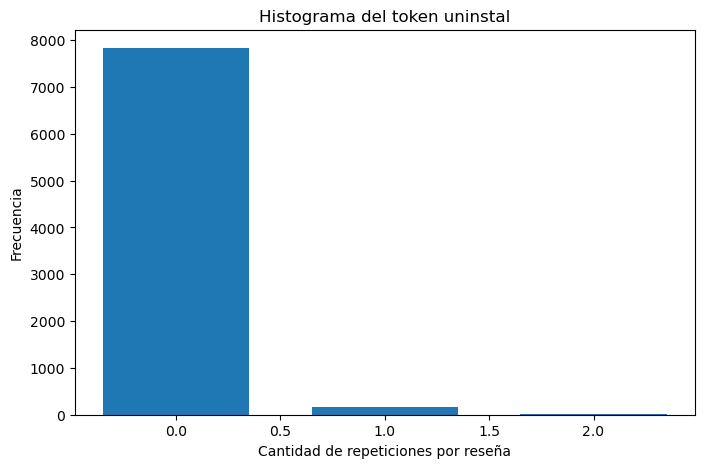

In [72]:
tokens_analysis(tokens_analisis[0],list(keys[0])[0])

In [73]:
totales_token=tokens_freq(tokens_analisis[0],list(keys[0])[0])
bins=totales_token[0]
total=totales_token[2]
j=0
for i in bins:
    print('El token',tokens_analisis[0],'aparece ',i,' veces en el ',round((totales_token[1][j]/total)*100,2),'% de las reseñas')
    j+=1

El token uninstal aparece  0  veces en el  97.89 % de las reseñas
El token uninstal aparece  1  veces en el  2.01 % de las reseñas
El token uninstal aparece  2  veces en el  0.1 % de las reseñas


#### Token 'love' ####

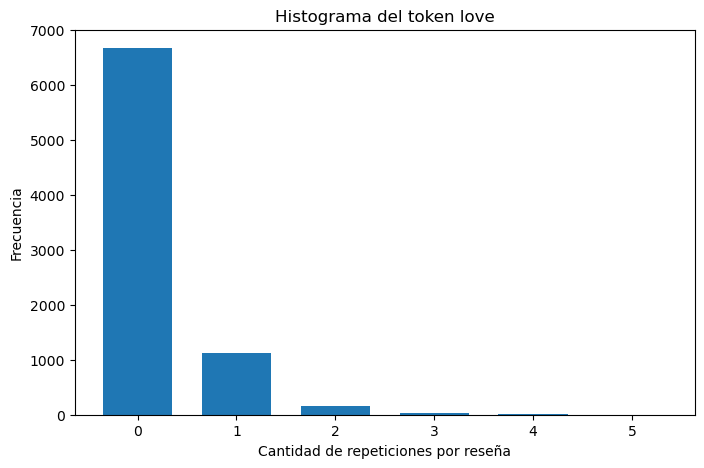

In [74]:
tokens_analysis(tokens_analisis[1],list(keys[1])[0])

In [75]:
totales_token=tokens_freq(tokens_analisis[1],list(keys[1])[0])
bins=totales_token[0]
total=totales_token[2]
j=0
for i in bins:
    print('El token',tokens_analisis[1],'aparece ',i,' veces en el ',round((totales_token[1][j]/total)*100,2),'% de las reseñas')
    j+=1

El token love aparece  0  veces en el  83.41 % de las reseñas
El token love aparece  1  veces en el  14.15 % de las reseñas
El token love aparece  2  veces en el  2.0 % de las reseñas
El token love aparece  3  veces en el  0.29 % de las reseñas
El token love aparece  4  veces en el  0.12 % de las reseñas
El token love aparece  5  veces en el  0.03 % de las reseñas


#### Token 'great' ####

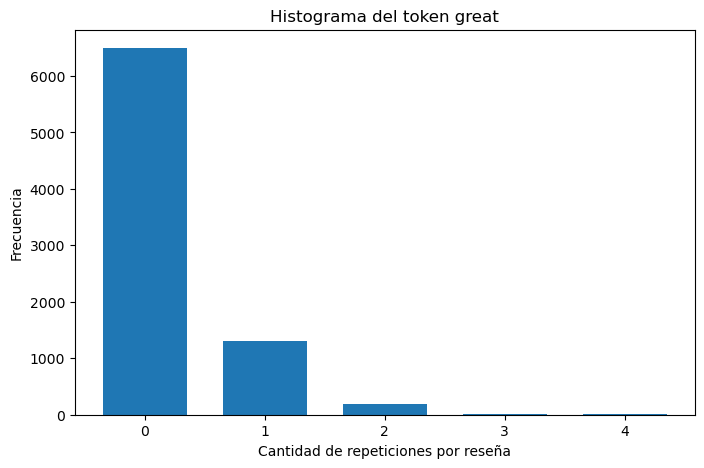

In [76]:
tokens_analysis(tokens_analisis[2],list(keys[2])[0])

In [77]:
totales_token=tokens_freq(tokens_analisis[2],list(keys[2])[0])
bins=totales_token[0]
total=totales_token[2]
j=0
for i in bins:
    print('El token',tokens_analisis[2],'aparece ',i,' veces en el ',round((totales_token[1][j]/total)*100,2),'% de las reseñas')
    j+=1

El token great aparece  0  veces en el  81.2 % de las reseñas
El token great aparece  1  veces en el  16.28 % de las reseñas
El token great aparece  2  veces en el  2.29 % de las reseñas
El token great aparece  3  veces en el  0.18 % de las reseñas
El token great aparece  4  veces en el  0.06 % de las reseñas


#### Token 'wast' ####

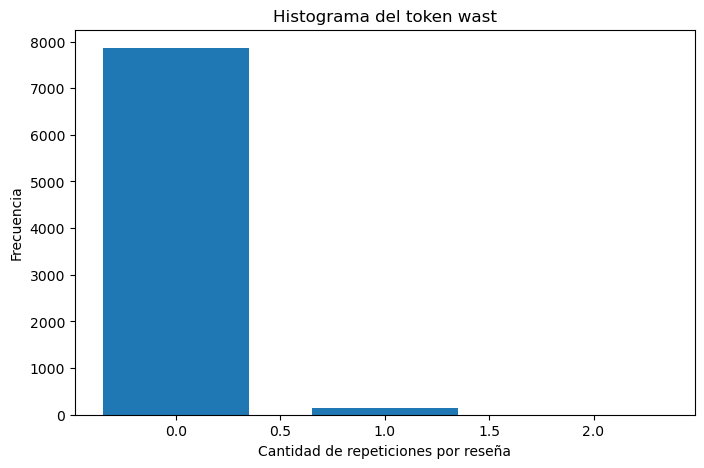

In [78]:
tokens_analysis(tokens_analisis[3],list(keys[3])[0])

In [79]:
totales_token=tokens_freq(tokens_analisis[3],list(keys[3])[0])
bins=totales_token[0]
total=totales_token[2]
j=0
for i in bins:
    print('El token',tokens_analisis[3],'aparece ',i,' veces en el ',round((totales_token[1][j]/total)*100,2),'% de las reseñas')
    j+=1

El token wast aparece  0  veces en el  98.25 % de las reseñas
El token wast aparece  1  veces en el  1.7 % de las reseñas
El token wast aparece  2  veces en el  0.05 % de las reseñas


#### Token 'delet' ####

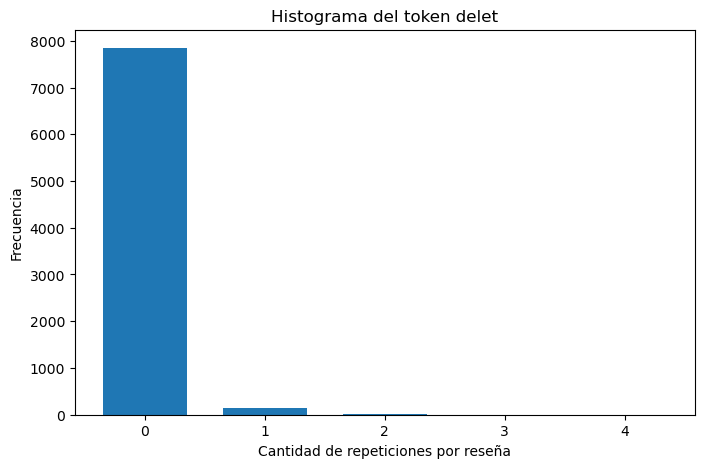

In [80]:
tokens_analysis(tokens_analisis[4],list(keys[4])[0])

In [81]:
totales_token=tokens_freq(tokens_analisis[4],list(keys[4])[0])
bins=totales_token[0]
total=totales_token[2]
j=0
for i in bins:
    print('El token',tokens_analisis[4],'aparece ',i,' veces en el ',round((totales_token[1][j]/total)*100,2),'% de las reseñas')
    j+=1

El token delet aparece  0  veces en el  98.05 % de las reseñas
El token delet aparece  1  veces en el  1.74 % de las reseñas
El token delet aparece  2  veces en el  0.18 % de las reseñas
El token delet aparece  3  veces en el  0.03 % de las reseñas
El token delet aparece  4  veces en el  0.01 % de las reseñas


#### Token 'bore' ####

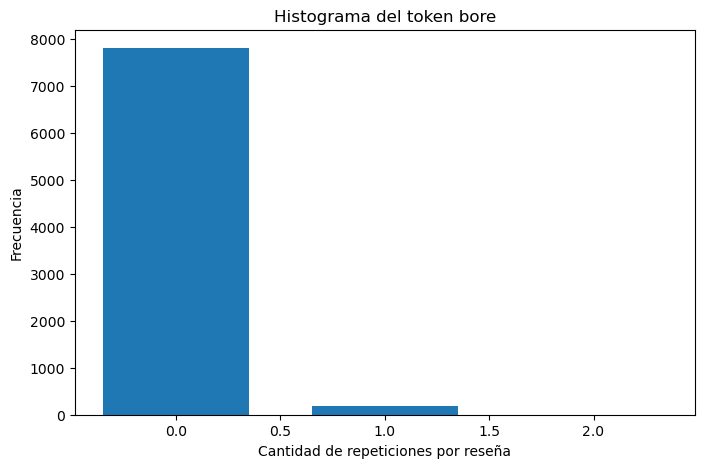

In [82]:
tokens_analysis(tokens_analisis[5],list(keys[5])[0])

In [83]:
totales_token=tokens_freq(tokens_analisis[5],list(keys[5])[0])
bins=totales_token[0]
total=totales_token[2]
j=0
for i in bins:
    print('El token',tokens_analisis[5],'aparece ',i,' veces en el ',round((totales_token[1][j]/total)*100,2),'% de las reseñas')
    j+=1

El token bore aparece  0  veces en el  97.62 % de las reseñas
El token bore aparece  1  veces en el  2.34 % de las reseñas
El token bore aparece  2  veces en el  0.04 % de las reseñas


<div class="alert alert-block alert-info">
<strong>Análisis:</strong> 

¿Que distribución presentan los datos?, ¿a qué crees que es debido?
</div>

- Los tokens uninstal, bore, delet, wast aparecen en aproximadamente el 1.5% y 2% de reseñas sólo una vez.  En cambio los tokens love y great tienen más frecuencia de aparición:
- El token great no aparece en aproximadamente el 80% de reseñas, aparece una vez en el 16% y aparece dos veces en el 2%. 
- El token love no aparece en aproximadamente el 80% de reseñas, aparece una vez en el 14% y dos veces en el 2%, también tiene un porcentaje muy bajo (menor al 1%) de reseñas en las que aparece 3 veces, 4 veces y hasta 5 veces. 
La aparición de las palabras love y great en una mayor cantidad de reseñas que las palabras delet, wast,bore, uninstal, es un buen indicador ya que las reseñas parecerían ser positivas si poseen palabras como love o great.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Repite los histogramas separando por colores la variable objetivo (dentro del mismo gráfico, diferenciar entre si la reseña es buena o no).
    
<u>Nota</u>: puedes utilizar el parámetro `alpha` para que se vean los dos gráficos a la vez.
</div>

In [84]:
#Creo funcion para graficar los histogramas de los tokens diferenciando el target 1 o 0:
def tokens_analysis_target(token,key,alpha1, alpha0):
    bins = list(set([X_train_1[i][key] for i in range(0,len(X_train_1))]))
    bins.append(bins[-1]+1)
    
    counts1, bins1 = np.histogram([X_train_1[i][key] for i in range(0,len(X_train_1))], bins=bins)
    counts0, bins0 = np.histogram([X_train_0[i][key] for i in range(0,len(X_train_0))], bins=bins)

    plt.figure(figsize=(8,5))
    plt.hist(bins[:-1], bins = bins1, weights=counts1, rwidth=0.7, align='left', alpha = alpha1, color = 'g', label='buena reseña')
    plt.hist(bins[:-1], bins = bins0, weights=counts0, rwidth=0.7, align='left', alpha = alpha0, color = 'g',label='mala reseña')
    plt.legend()
    plt.title('Histograma del token %s' %token)
    plt.xlabel('Cantidad de repeticiones por reseña')
    plt.ylabel('Frecuencia')
    plt.show()

In [85]:
df_Train  = pd.DataFrame(
    {'X_train': X_train,
     'target': y_train
    })

df_Train.head()

,X_train,target
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
4,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1


In [86]:
#Separo las rese;as entre el target:
X_train_1 = list(df_Train[df_Train['target'] == 1]['X_train'])
X_train_0 = list(df_Train[df_Train['target'] == 0]['X_train'])

#### Token 'uninstal' ####

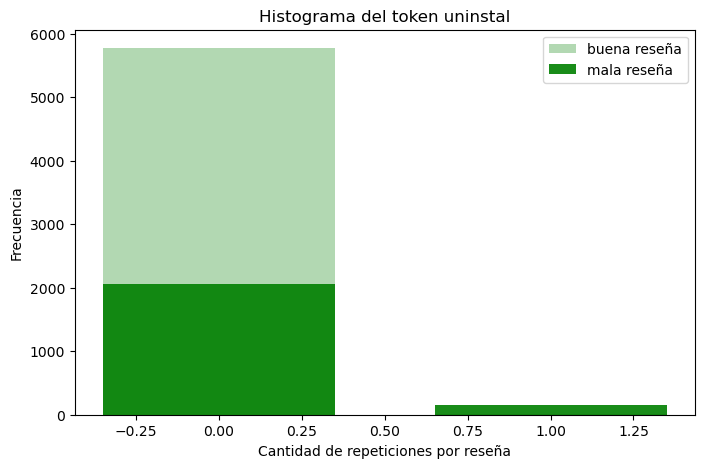

In [87]:
tokens_analysis_target(tokens_analisis[0],list(keys[0])[0],0.3, 0.9)

#### Token 'love' ####

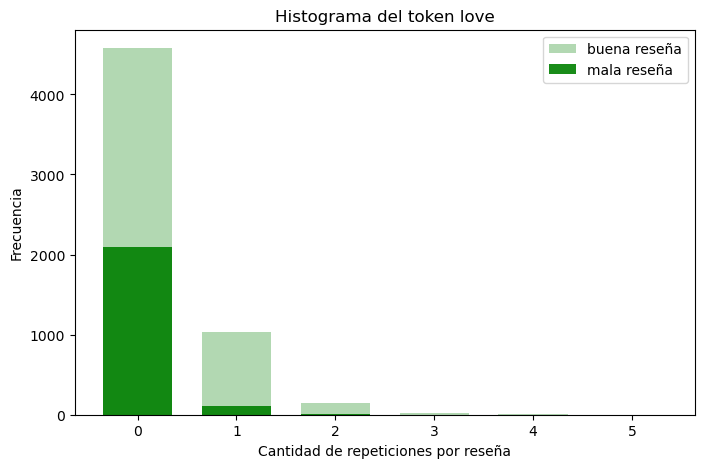

In [88]:
tokens_analysis_target(tokens_analisis[1],list(keys[1])[0],0.3, 0.9)

#### Token 'great' ####

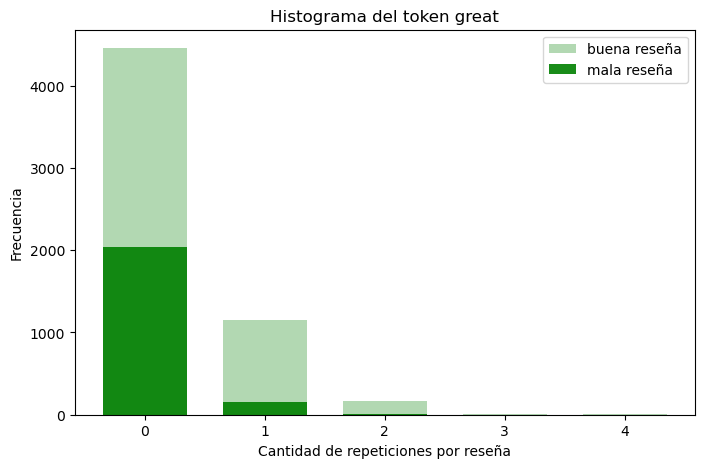

In [89]:
tokens_analysis_target(tokens_analisis[2],list(keys[2])[0],0.3, 0.9)

#### Token 'wast' ####

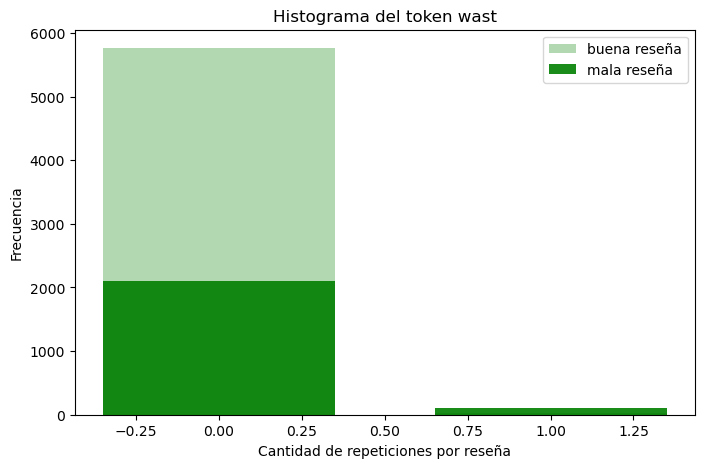

In [90]:
tokens_analysis_target(tokens_analisis[3],list(keys[3])[0],0.3, 0.9)

#### Token 'delet' ####

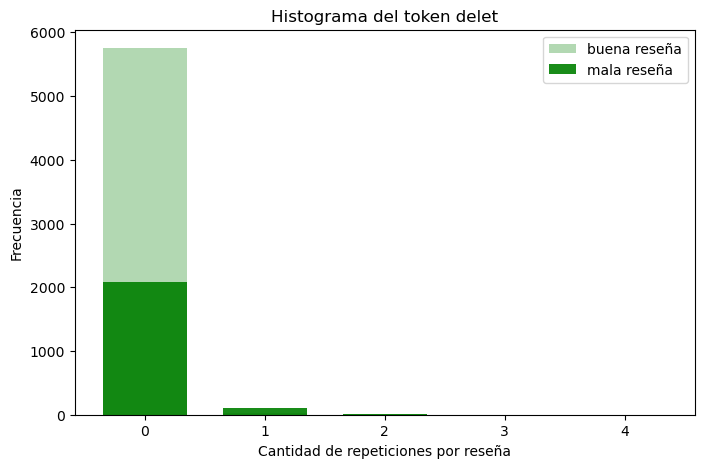

In [91]:
tokens_analysis_target(tokens_analisis[4],list(keys[4])[0],0.3, 0.9)

#### Token 'bore' ####

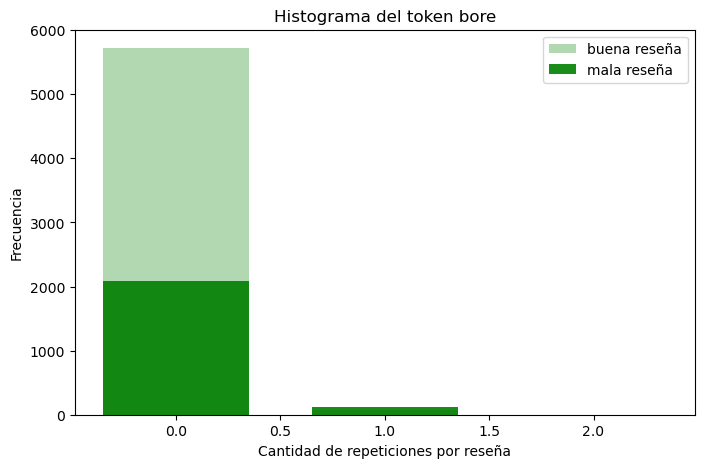

In [92]:
tokens_analysis_target(tokens_analisis[5],list(keys[5])[0],0.3, 0.9)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> 

¿Qué conclusiones puedes sacar de estas últimas gráficas?
</div>

- Al separar los histogramas por la variable target (reseña buena o mala) podemos ver que para los tokens: uninstal, bore, delet y wast, los casos en los que aparecen una vez o más en las reseñas corresponden a 'malas reseñas', lo cual es esperable, y vemos que el conjunto de 'buenas reseñas' está todo concentrado en 0 veces. 
- Para el caso del token great vemos que para las reseñas en las que aparece 1 vez, más de la mitad son 'buenas reseñas' aunque tabmién aparece esta palabra una vez en algunas reseña clasificadas como malas. Lo mismo ocurre con las reseñas en las que la palabra great aparece dos veces, la mayoría de estas corresponden a buenas reseñas pero hay un pequeño porcentaje de ellas que son clasificadas como malas (es decir overall < 3) y tienen este token dos veces.
- Por último, con el token love ocurre algo muy parecido a lo que ocurre con great, en el grupo de rseñas que aparece una vez y dos veces son mayoría las buenas reseñas, pero igualmente hay algunas malas reseñas con este token una o dos veces.

#### 2.3. Entrenamiento del modelo

En este subapartado construiremos varios modelos con las ténicas vistas previamente y estudiaremos su comportamiento.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Construye un árbol de decisión de profundidad 3 con las muestras del conjunto de entrenamiento.

Evalúa la capacidad predictiva del modelo con las métricas de `accuracy` y `roc_auc`, tanto en el subconjunto de entrenamiento como en el de test.
</div>

In [93]:
accuracy_scores_train=[]
accuracy_scores_test=[]
roc_auc_train=[]
roc_auc_test=[]
model_clf=[]

In [94]:
clfTree = DecisionTreeClassifier(max_depth = 3)
clfTree.fit(X_train, y_train)

#Predecimos los labels del conjunto de train:
y_train_pred = clfTree.predict(X_train)
#Predecimos los labels del conjunto de testeo:
y_test_pred = clfTree.predict(X_test)

In [95]:
accuracy_tree_test = accuracy_score(y_test, y_test_pred)
accuracy_tree_train = accuracy_score(y_train, y_train_pred)

accuracy_scores_train.append(accuracy_tree_train)
accuracy_scores_test.append(accuracy_tree_test)
model_clf.append('Decision Tree')

print('Model accuracy score test: {0:0.2f}'. format(accuracy_tree_test))
print('Model accuracy score train: {0:0.2f}'. format(accuracy_tree_train))

Model accuracy score test: 0.74
Model accuracy score train: 0.74


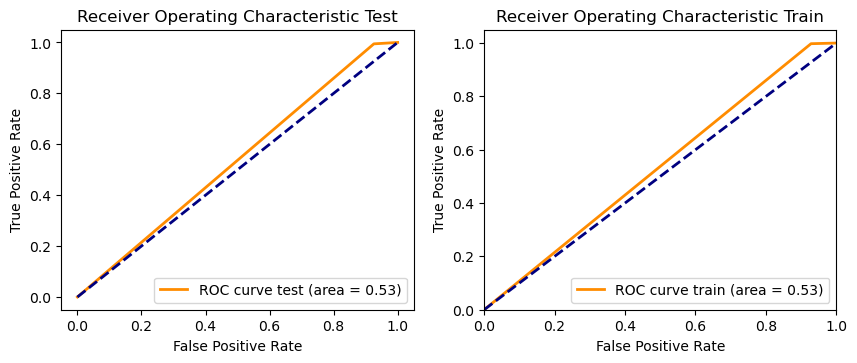

In [96]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve test (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Test')
plt.legend(loc="lower right")

roc_auc_test.append(roc_auc)

fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
roc_auc = auc(fpr, tpr)
plt.subplot(2,2,2)
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve train (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Train')
plt.legend(loc="lower right")
plt.show()

roc_auc_train.append(roc_auc)

El área debajo de la curva representa la habilidad del modelo para discriminar entre la clase negativa y la positiva. Un área de 1 representa un modelo que ha hecho todas las predicciones perfectas, mientras que un área de 0.5 representa el rendimiento de un modelo aleatorio. En este caso, tanto para el conjunto de test como el de train. el area es 0,53. Lo cual es casi un resultado donde el modelo clasifica de forma aleatoria.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Comprueba qué atributos son los más importantes del árbol mostrando sus nodos y los pares variable-valor que utiliza cada uno de ellos para dividir y subdividir los datos. Es importante que en los nodos del árbol aparezca a qué token hace referencia.

<u>Nota:</u> el siguiente enlace muestra una forma elegante de visualizar los nodos de los árboles: https://mljar.com/blog/visualize-decision-tree/.
</div>

In [97]:
features=list(vocabulary_dictionary.values())

In [98]:
str_features = [str(int) for int in features]
target = list(set(y))
str_target = [str(int) for int in target]
text_representation = tree.export_text(clfTree, feature_names = features)
print(text_representation)

|--- uninstal <= 0.50
|   |--- love <= 0.50
|   |   |--- great <= 0.50
|   |   |   |--- class: 1
|   |   |--- great >  0.50
|   |   |   |--- class: 1
|   |--- love >  0.50
|   |   |--- updat <= 1.50
|   |   |   |--- class: 1
|   |   |--- updat >  1.50
|   |   |   |--- class: 0
|--- uninstal >  0.50
|   |--- dictionari <= 0.50
|   |   |--- ok <= 0.50
|   |   |   |--- class: 0
|   |   |--- ok >  0.50
|   |   |   |--- class: 1
|   |--- dictionari >  0.50
|   |   |--- go <= 1.00
|   |   |   |--- class: 1
|   |   |--- go >  1.00
|   |   |   |--- class: 0



En cuanto a las reglas de decisión que creó el modelo podemos ir describiendolas de la siguiente manera:
Regla 1: Si se cumple que:
- uninstal <= 0.5, y
- love <= 0.5, y
- great <= 0.5 o great > 0.5
- Entonces le corresponde la class: 1

En nuestro caso los valores de las variables son 0,1 (es decir el token está en la reseña o no está), entonces se traduciría como: Si el token 'uninstal' no está en la reseña, y el token 'love' tampoco está, y great está o no esta entonces le corresponde clase 1. 

Y asi sucesivamente con las siguientes reglas.

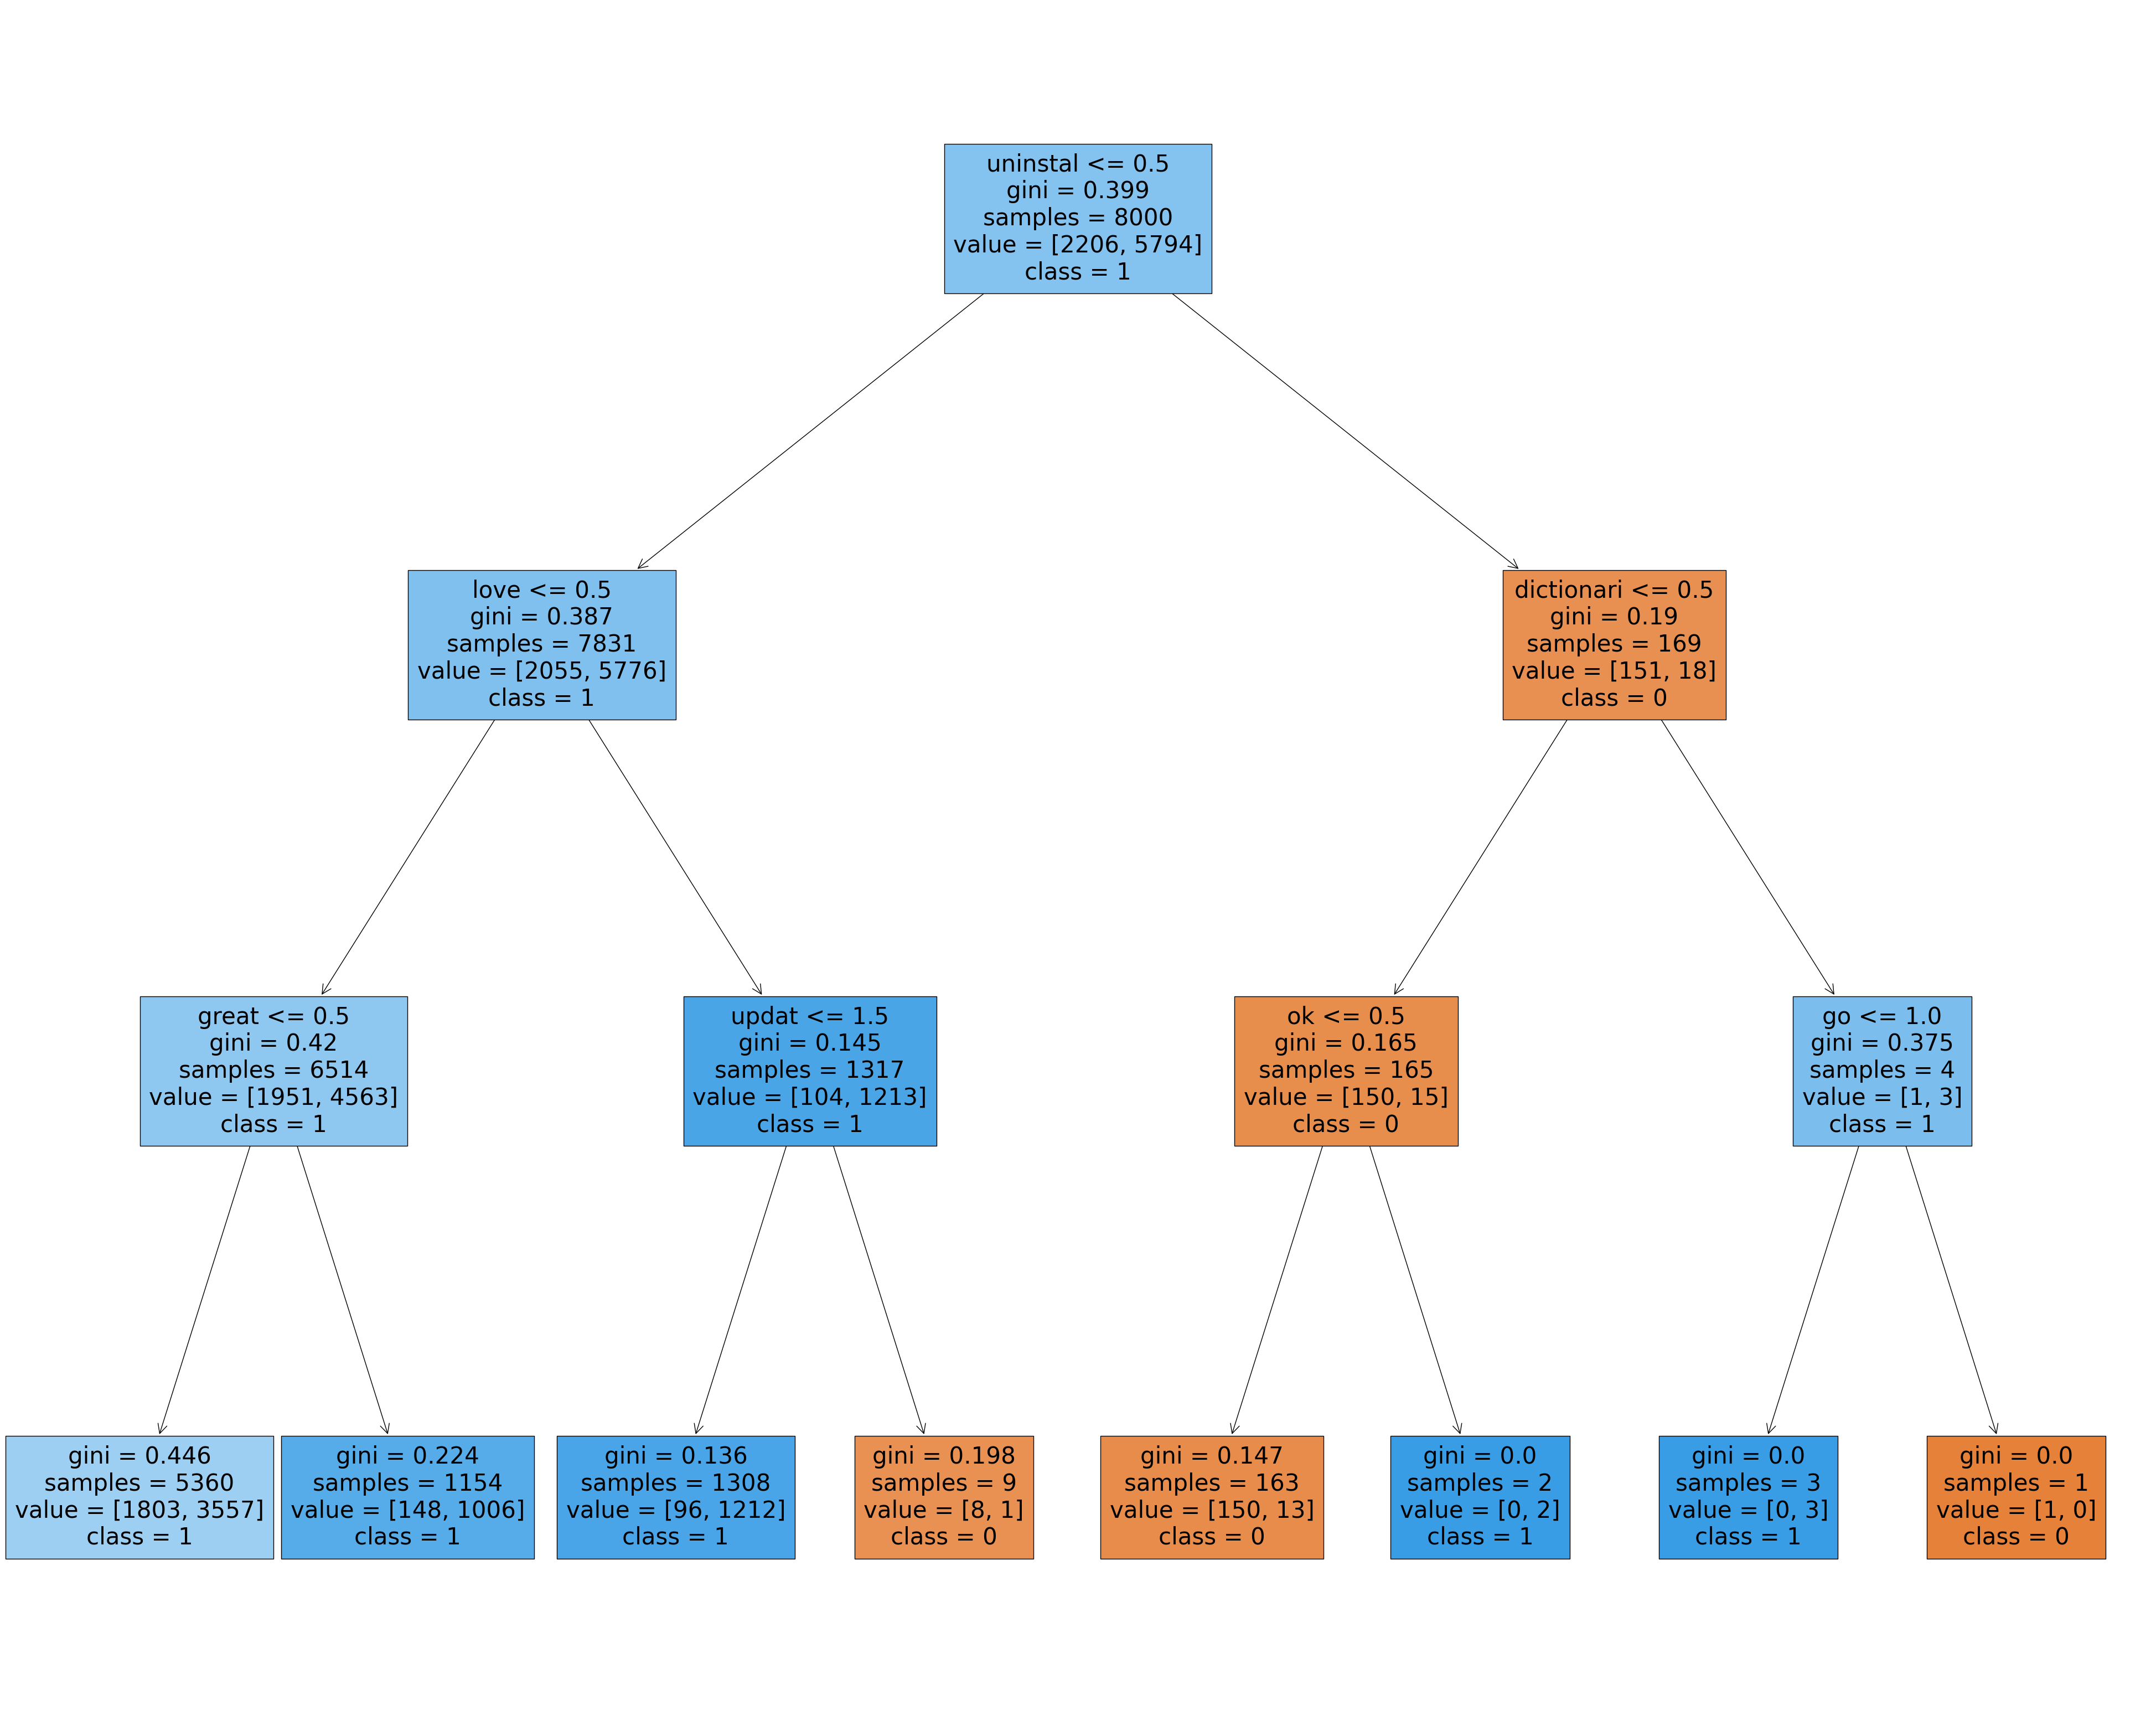

In [99]:
fig = plt.figure(figsize=(50,40))
_ = tree.plot_tree(clfTree, 
                   feature_names=str_features,  
                   class_names=str_target,
                   filled=True,
                  max_depth = 3)

En el grafico de arriba vemos la estructura del árbol de decisión, en cada nodo de decisión realiza el cálculo del índice Gini, el cual lo podemos definir como una función de costo utilizada para evaluar divisiones en el conjunto de datos, esta medida establece que el mejor separador es aquel que reduce la diversidad de las particioneso entropia. Específicamente el índice Gini calcula la probabilidad de que una observación se clasifique incorrectamente cuando se selecciona al azar, es decir que cuanto menor sea este índice mejor será.
Vemos que como primer nodo selecciona el token uninstal <= 0.5 y a partir de aqui realiza la primera partición de los datos, dividiendo el dataset por esta variable obtiene un valor Gini de 0.399, el cual es el mínimo valor que obtuvo por eso seleccionó este atributo para comenzar. Luego, el dataset se divide en dos grupos teniendo en cuenta la condición anterior, y en cada uno de estos grupos vuelve a calcular el valor Gini para encontrar el atributo que mejor separe los datos, es decir aquel atributo que reduzca al máximo la diversidad de las siguientes particiones, una vez que se encuentra el mejor separador, éste se convierte en la raiz del árbol y se vuelve a proceder del mismo modo. Cuando ya no se encuentren más separadores, el nodo queda como una hoja terminal.

El gráfico nos ayuda a entender cómo el árbol va tomando las decisiones y particionando las observaciones en cada nodo. En el primer caso vemos que divide la muestra según el valor del token uninstal, luego, en el nodo de la izquierda divide esta nueva muestra teniendo en cuenta el valor del token love y en el nodo de la derecha según el token dictionari. 
En el tercer nivel tenemos a la muestra que correspondía a valores de 'love' menores a 0.5 (es decir comentarios que no tengan 'love'), para esta muestra usa el token 'great' para forman la clasificación final, que podemos observar que no quedaron totalmente puras es decir todas las observaciones no son de la clase 1, sino que hay datos que pertenecen a la clase 2.
Por otro lado, la muestra que tiene comentarios con el token 'love' al menos una vez la vuelve a dividir teniendo en cuenta el token 'updat' y llega a la clasificación final donde también vemos que la clasificación final a la que llega tampoco es totalmente pura (update <= 1.5 -> clase 1, update > 1.5 -> clase 0).
Por el lado de la muestra que surge del token 'dictionari', separa aquellas reseñas con el token dictionari <= a 0.5 y la vuelve a separar teniendo en cuenta el token 'ok', y aquellas con el token > 0.5 las separa teniendo en cuenta el token 'limit', en este caso las ramificaciones que se obtienen son puras con un indice gini = 0 (es decir todas las observaciones pertenecen a la misma clase.

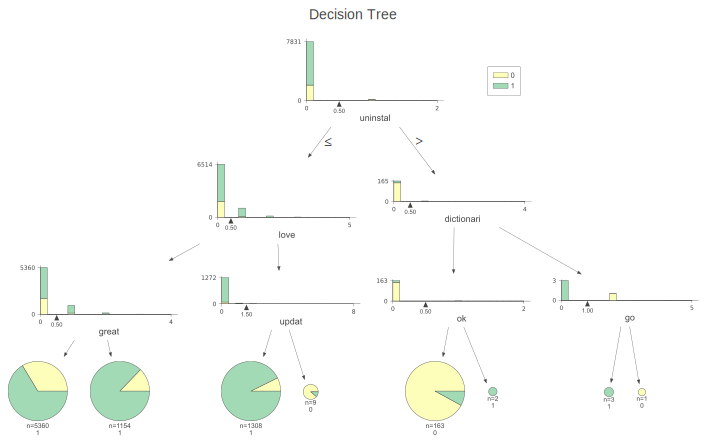

In [160]:
viz = dtreeviz(clfTree, 
               np.array(X_train),
               y_train,
               feature_names=str_features, 
               class_names=['0', '1'],
               title='Decision Tree'
            )

viz

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> 

Según el árbol de decisión, ¿qué tokens son los más importantes a la hora de discriminar si un comentario es bueno o no?
</div>

Los tokens más importantes para discriminar los comentarios entre buenos o malos es en primer lugar 'uninstal', seguido por 'love' y 'dictionari'. 

Otra buena forma de analizar qué atributos descriptivos son los más interesantes para discriminar a qué clase pertenece cada muestra es construir un _random forest_ para estudiar la _feature importance_ de los atributos descriptivos.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Calcula el valor óptimo de los hiperparámetros `max_depth` y `n_estimators` para un `RandomForestClassifier`. Utiliza una búsqueda de rejilla con la métrica `roc_auc` y con validación cruzada para encontrar los valores óptimos. Para cada combinación de valores, calcula su promedio y la desviación estándar de dicha métrica.
    
Puedes utilizar el módulo `GridSearchCV` de `sklearn` para obtener la mejor combinación de hiperparámetros.
</div>

In [103]:
# Grilla para Grid Search
param_grid = {'max_depth' : [3,4,5,6,7,8,9,10,11,12], 
              'n_estimators': [10,50,100,200]
             } 
#Modelo a usar:
forest_clf = RandomForestClassifier()
model = GridSearchCV(forest_clf, param_grid, cv=4, scoring='accuracy')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [104]:
# Mejor estimador
print(model.best_estimator_)

RandomForestClassifier(max_depth=12, n_estimators=200)


<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Con la mejor configuración de hiperparámetros encontrada, construye un modelo de clasificación con _random forest_.

Evalúa la capacidad predictiva del modelo con las métricas de `accuracy` y `roc_auc`, tanto en el subconjunto de entrenamiento como en el de test.
</div>

In [105]:
forest_clf = RandomForestClassifier(max_depth = 12, n_estimators = 200)
forest_clf.fit(X_train, y_train)

#Predecimos los labels del conjunto de testeo:
y_test_pred = forest_clf.predict(X_test)
#Predecimos los labels del conjunto de entrenamiento:
y_train_pred = forest_clf.predict(X_train)

In [106]:
accuracy_random_forest_test = accuracy_score(y_test, y_test_pred)
accuracy_random_forest_train = accuracy_score(y_train, y_train_pred)

accuracy_scores_train.append(accuracy_random_forest_train)
accuracy_scores_test.append(accuracy_random_forest_test)
model_clf.append('Random Forest')

print('Model accuracy score test: {0:0.2f}'. format(accuracy_random_forest_test))
print('Model accuracy score train: {0:0.2f}'. format(accuracy_random_forest_train))

Model accuracy score test: 0.77
Model accuracy score train: 0.78


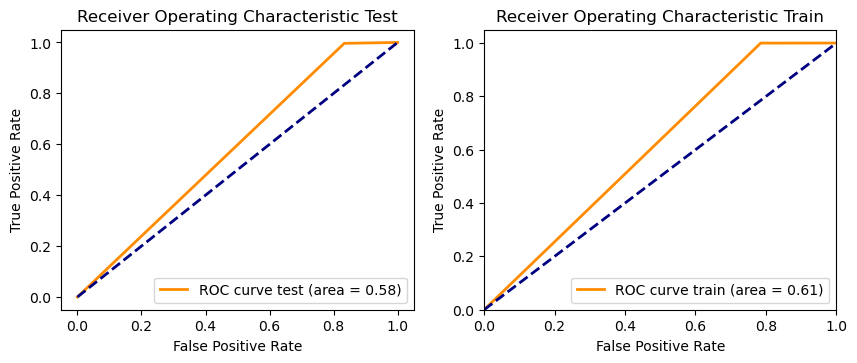

In [107]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve test (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Test')
plt.legend(loc="lower right")

roc_auc_test.append(roc_auc)

fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
roc_auc = auc(fpr, tpr)
plt.subplot(2,2,2)
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve train (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Train')
plt.legend(loc="lower right")

roc_auc_train.append(roc_auc)

plt.show()

Tanto el accuracy como el area bajo la curva ROC mejoran con el modelo de Random Forest vs el Arbol de clasificación individual. 
También podemos mencionar que los valores del conjunto de train son un poco más elevados que los del conjunto de test.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Con el modelo de _random forest_ construido, muestra cuáles son los tokens más importantes para discriminar a qué clase pertenece cada muestra según el modelo.

<u>Nota:</u> utiliza el atributo `feature_importances_` del modelo de _random forest_ creado.
</div>

In [108]:
importancia = forest_clf.feature_importances_
label = str_features
feat_import = {'Atributos': label, 'Importancia': importancia}
dataset = pd.DataFrame(data=feat_import)
dataset.sort_values(by = 'Importancia', ascending = False)

,Atributos,Importancia
203,love,0.068387
43,uninstal,0.067195
266,great,0.064131
292,delet,0.044697
89,wast,0.044588
...,...,...
38,hangman,0.000182
37,daughter,0.000164
381,absolut,0.000155
401,remind,0.000115


La importancia de cada característica se calcula como la disminución de la impureza del nodo ponderada por la probabilidad de alcanzar ese nodo. La probabilidad del nodo se puede calcular por el número de muestras que llegan al nodo, dividido por el número total de muestras. Cuanto mayor sea el valor, más importante será la característica. 
Vemos en el listado que el token más importante para discriminar si un comentario es bueno o malo en este modelo, con aproximadamente el 8% es 'uninstal', seguido por 'love','great' y 'wast'.

Tradicionalmente, modelos probabilísticos como el de Naïve-Bayes han demostrado ser bastante efectivos con problemas similares.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Construye un modelo con `GaussianNB`.

Evalúa la capacidad predictiva del modelo con las métricas de `accuracy` y `roc_auc`, tanto en el subconjunto de entrenamiento como en el de test.
</div>

In [109]:
#instancio el clasificador:
clfBayes = GaussianNB()
#Entrenamos el modelo
clfBayes.fit(X_train, y_train)

#Predecimos los labels del conjunto de testeo:
y_test_pred = clfBayes.predict(X_test)
#Predecimos los labels del conjunto de entrenamiento:
y_train_pred = clfBayes.predict(X_train)

In [110]:
accuracy_bayes_test = accuracy_score(y_test, y_test_pred)
accuracy_bayes_train = accuracy_score(y_train, y_train_pred)

accuracy_scores_train.append(accuracy_bayes_train)
accuracy_scores_test.append(accuracy_bayes_test)
model_clf.append('Naive Bayes')

print('Model accuracy score test: {0:0.2f}'. format(accuracy_bayes_test))
print('Model accuracy score train: {0:0.2f}'. format(accuracy_bayes_train))

Model accuracy score test: 0.75
Model accuracy score train: 0.76


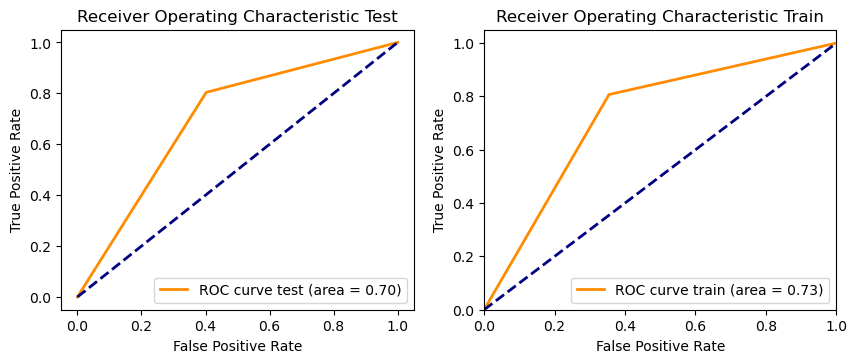

In [111]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve test (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Test')
plt.legend(loc="lower right")

roc_auc_test.append(roc_auc)


fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
roc_auc = auc(fpr, tpr)
plt.subplot(2,2,2)
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve train (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Train')
plt.legend(loc="lower right")

roc_auc_train.append(roc_auc)


plt.show()

La habilidad del modelo para discriminar entre la clase buena o mala ha mejorado con el clasificar Naive Bayes, pasó de un área bajo la curva ROC de 0,56 en el modelo Random Forest a 0,7 con este modelo.

Finalmente, comprobaremos qué tal se comporta un clasificador lineal en nuestro problema.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Construye un modelo con `SVC` con `kernel` lineal.

Evalúa la capacidad predictiva del modelo con las métricas de `accuracy` y `roc_auc`, tanto en el subconjunto de entrenamiento como en el de test.
</div>

In [112]:
clfSVM = SVC(kernel='linear')
clfSVM.fit(X_train, y_train)

#Predecimos los labels del conjunto de testeo:
y_test_pred = clfSVM.predict(X_test)
#Predecimos los labels del conjunto de entrenamiento:
y_train_pred = clfSVM.predict(X_train)

In [113]:
accuracy_svm_test = accuracy_score(y_test, y_test_pred)
accuracy_svm_train = accuracy_score(y_train, y_train_pred)

accuracy_scores_train.append(accuracy_svm_train)
accuracy_scores_test.append(accuracy_svm_test)
model_clf.append('SVM')

print('Model accuracy score test: {0:0.2f}'. format(accuracy_svm_test))
print('Model accuracy score train: {0:0.2f}'. format(accuracy_svm_train))

Model accuracy score test: 0.81
Model accuracy score train: 0.84


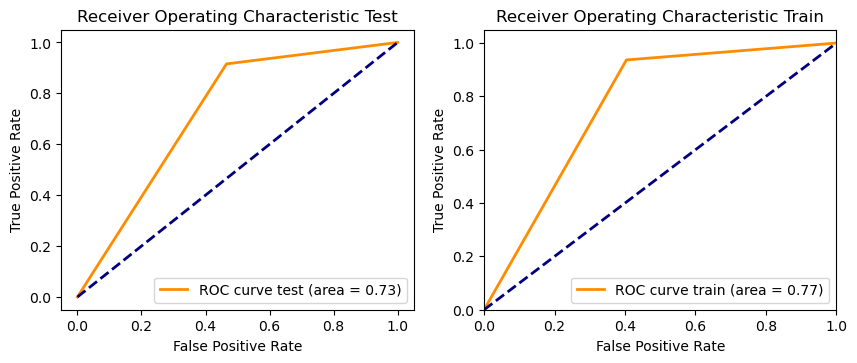

In [114]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve test (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Test')
plt.legend(loc="lower right")

roc_auc_test.append(roc_auc)

fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
roc_auc = auc(fpr, tpr)
plt.subplot(2,2,2)
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve train (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Train')
plt.legend(loc="lower right")

roc_auc_train.append(roc_auc)


plt.show()

En este caso los valores de accuracy y el area bajo la curva ROC tanto del conjunto test como  train son los más altos hasta ahora. Es decir el modelo de SVM es el que ha logrado mejor la separacion entre las clases y ha podido clasificar mejor que los demas modelos.

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> 

Comenta los resultados obtenidos.
</div>

En el gráfico siguiente vemos los resultados del accuracy y el área bajo la curva ROC para el conjunto de entrenamiento y para el conjunto de test, para cada uno de los cuatro modelos que probamos:

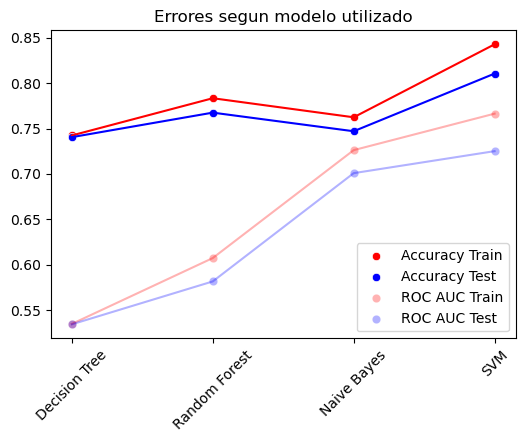

In [115]:
plt.figure( figsize = (6,4))
sns.scatterplot(x = model_clf, y = accuracy_scores_train, color = 'red', label='Accuracy Train')
sns.scatterplot(x = model_clf, y = accuracy_scores_test, color = 'blue', label='Accuracy Test')
plt.plot(accuracy_scores_train, color = 'red')
plt.plot(accuracy_scores_test, color = 'blue')
sns.scatterplot(x = model_clf, y = list(roc_auc_train), color = 'red', label='ROC AUC Train', alpha=0.3)
sns.scatterplot(x = model_clf, y = list(roc_auc_test), color = 'blue', label='ROC AUC Test',alpha=0.3)
plt.plot(list(roc_auc_train), color = 'red',alpha=0.3)
plt.plot(list(roc_auc_test), color = 'blue',alpha=0.3)
plt.legend()
plt.xticks(rotation = 45)
plt.title('Errores segun modelo utilizado')
plt.show()

Podemos identificar rápidamente que los valores más altos de accuracy los tiene el modelo Support Vector Machine.
En cuanto a los valores de AUC ROC, vemos que el más alto se da para el set de entrenamiento del modelo SVM pero si observamos los valores para el conjunto de test, vemos que el resultado que se obtuvo con el modelo SVM es muy similar al que se obtuvo con el modelo Naive Bayes. 
La métrica del área bajo la curva ROC nos da una idea de la habilidad del modelo para distinguir entre las dos clases, en el caso del modelo Naive Bayes o SVM que tienen valores al rededor de 0.7, significa que hay 70% de probabilidad de que el modelo pueda distinguir entre clase positiva y clase negativa.
En cuanto a la métrica accuracy nos da la proporción de observaciones clasificadas correctamente por el modelo vs el total de observaciones.

#### 2.4. Predicción de nuevos casos

En este caso vamos a comprobar cómo se comporta el mejor de nuestros clasificadores con dos reseñas completamente nuevas.

In [116]:
new_reviews = [
    {
        'reviewText': "The best application ever!!!",
        'overall': 5.0,
    },
    {
        'reviewText': "The worst application ever :'(",
        'overall': 1.0,
    },
]

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

Con el mejor de los modelos creados, predice si estas dos nuevas reseñas son buenas o no.
</div>

In [117]:
new_reviews[0]['reviewText']

'The best application ever!!!'

In [118]:
new_reviews_tokens=[]
new_reviews_tokens.append(process_review(new_reviews[0])[0])
new_reviews_tokens.append(process_review(new_reviews[1])[0])

In [119]:
new_reviews_tokens

[['best', 'applic', 'ever'], ['worst', 'applic', 'ever']]

In [120]:
counter={}
X_new_reviews=[]
for i in range(0,len(new_reviews_tokens)):
    counter = Counter(new_reviews_tokens[i])
    array=[]
    count=0
    for key,values in vocabulary_dictionary.items():
        for v,k in counter.items(): #Si encuentra el token en la reseña asigna k a esa posicion sino 0 
            if(values == v):
                array.append(k)
            else:
                count+=1
        if(count== len(counter.items())): array.append(0)
        count=0
    X_new_reviews.append(array)

Vamos a predecir si las dos nuevas reseñas son buenas o malas usando el modelo de Support Vector Machine y el Naive Bayes:

In [121]:
clfSVM.predict(X_new_reviews)

array([1, 1])

In [122]:
clfBayes.predict(X_new_reviews)

array([1, 0])

El modelo Naive Bayes ha logrado clasificar correctamente a las dos nuevas reseñas.

#### 2.5. BONUS

Comprueba si las deducciones obtenidas para las reseñas de aplicaciones de Android tienen sentido en otro tipo de productos.

Descárgate las reseñas de otro tipo de producto y compruébalo.

Para el bonus elegí un dataset llamado: Amazon Customer Reviews que contiene reseñas sobre productos vendidos a través de Amazon, incluye desde alimentos hasta varios productos como máquinas de café.
link: https://www.kaggle.com/datasets/vivekprajapati2048/amazon-customer-reviews

In [161]:
data = pd.read_csv("Reviews.csv")
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [213]:
data.shape

(568454, 10)

Dado que el dataset tiene más de 500.000 registros, voy a tomar una pequeña muestra aleatoria de 1000 registros:

In [269]:
Reviews = pd.DataFrame(data, columns = ['Text','Score'])
Reviews = Reviews.sample(n=1000)
Reviews=Reviews.reset_index()
Reviews.head()

,index,Text,Score
0,463103,"This is really good stuff, but use VERY sparin...",5
1,204801,"Excellent flavor, and a simple addition to you...",5
2,546772,This is the brand recommended by my vet and my...,5
3,488827,"For 11 bucks a box, I was not expecting this t...",4
4,251240,My in-laws have a very food-driven feline who ...,5


In [262]:
Revies.shape

(1000, 2)

In [270]:
Reviews.rename(columns = {'Text':'reviewText', 'Score': 'overall'}, inplace = True)
Reviews=Reviews.drop(columns=['index'])
Reviews.head()

,reviewText,overall
0,"This is really good stuff, but use VERY sparin...",5
1,"Excellent flavor, and a simple addition to you...",5
2,This is the brand recommended by my vet and my...,5
3,"For 11 bucks a box, I was not expecting this t...",4
4,My in-laws have a very food-driven feline who ...,5


Convierto la muestra a formato diccionario para poder usar la función process_review:

In [271]:
Reviews_dict = Reviews.T.to_dict()

In [273]:
Reviews_dict[0]

{'reviewText': 'This is really good stuff, but use VERY sparingly. One drop in a recipe will still be very strong.  Two drops on your tongue will be very hot and make your mouth numb for half and hour.',
 'overall': 5}

In [275]:
tokens_list = []
y_list = []
for i in range(0,len(Reviews_dict)) :
    tokens,is_good = process_review(Reviews_dict[i])
    tokens_list.append(tokens)
    y_list.append(1 if is_good else 0)

In [279]:
print('Hay', y_list.count(0),' reseñas malas y ',y_list.count(1), 'buenas')

Hay 205  reseñas malas y  795 buenas


Armo el conjunto de datos de entrenamiento y de test tomando el vocabulary_dictionary que armé para el dataset de reseñas para aplicaciones Android: Es decir para cada registro va a colocar un 1 o 0 dependiendo de si el token de la reseña está en el diccionario. 

In [ ]:
y = np.array(y_list)
X = tokens_list

#Train and Test
tokens_list_train, tokens_list_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 24, stratify=y)

In [281]:
#Creo la variable X_train usando el diccionario que arme para evaluar las reseñas de las apps Android:
counter={}
X_train=[]
for i in range(0,len(tokens_list_train)):
    counter = Counter(tokens_list_train[i])
    array=[]
    count=0
    for key,values in vocabulary_dictionary.items():
        for v,k in counter.items(): #Si encuentra el token en la reseña asigna k a esa posicion sino 0 
            if(values == v):
                array.append(k)
            else:
                count+=1
        if(count== len(counter.items())): array.append(0)
        count=0
    X_train.append(array)

In [285]:
#Creo la variable X_test:
counter={}
X_test=[]
for i in range(0,len(tokens_list_test)):
    counter = Counter(tokens_list_test[i])
    array=[]
    count=0
    for key,values in vocabulary_dictionary.items():
        for v,k in counter.items(): #Si encuentra el token en la rese;a asigna k a esa posicion sino 0 
            if(values == v):
                array.append(k)
            else:
                count+=1
        if(count== len(counter.items())): array.append(0)
        count=0
    X_test.append(array)

Genero un clasificador Naive Bayes, que fue el que pudo identificar bien las reviews anteriores:

In [286]:
#instancio el clasificador:
clfBayes = GaussianNB()
#Entrenamos el modelo
clfBayes.fit(X_train, y_train)

#Predecimos los labels del conjunto de testeo:
y_test_pred = clfBayes.predict(X_test)
#Predecimos los labels del conjunto de entrenamiento:
y_train_pred = clfBayes.predict(X_train)

In [287]:
print('Model accuracy score test: {0:0.2f}'. format(accuracy_score(y_test, y_test_pred)))
print('Model accuracy score train: {0:0.2f}'. format( accuracy_score(y_train, y_train_pred)))

Model accuracy score test: 0.34
Model accuracy score train: 0.40


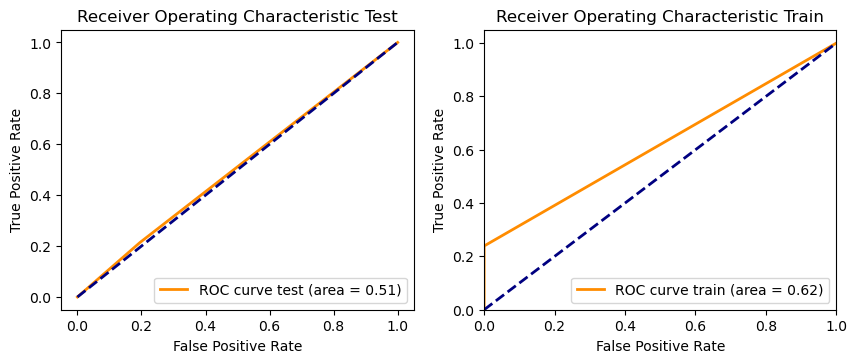

In [288]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve test (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Test')
plt.legend(loc="lower right")

fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
roc_auc = auc(fpr, tpr)
plt.subplot(2,2,2)
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve train (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Train')
plt.legend(loc="lower right")

plt.show()

Los resultados obtenidos con el modelo Naive Bayes son muy bajos, el área bajo la curva ROC es de 0.5 lo cual indica que las clasificaciones son aleatorias. 

Voy a probar con el clasificador usando el modelo Support Vector Machine con un kernel lineal:

In [289]:
clfSVM = SVC(kernel='linear')
clfSVM.fit(X_train, y_train)

#Predecimos los labels del conjunto de testeo:
y_test_pred = clfSVM.predict(X_test)
#Predecimos los labels del conjunto de entrenamiento:
y_train_pred = clfSVM.predict(X_train)

In [290]:
print('Model accuracy score test: {0:0.2f}'. format(accuracy_score(y_test, y_test_pred)))
print('Model accuracy score train: {0:0.2f}'. format( accuracy_score(y_train, y_train_pred)))

Model accuracy score test: 0.81
Model accuracy score train: 0.96


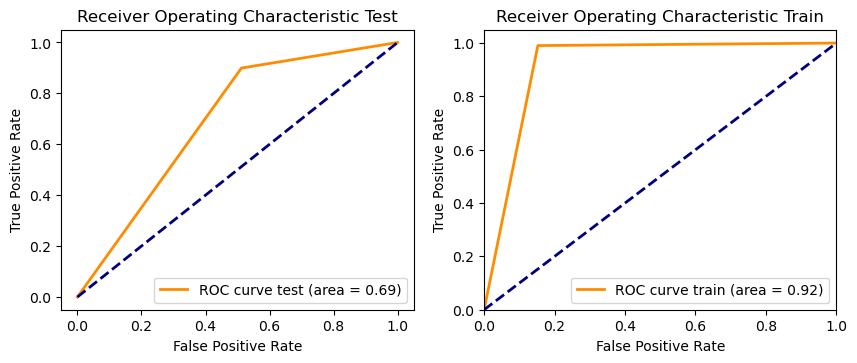

In [291]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve test (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Test')
plt.legend(loc="lower right")

fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
roc_auc = auc(fpr, tpr)
plt.subplot(2,2,2)
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve train (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Train')
plt.legend(loc="lower right")

plt.show()

En este caso vemos que el resultado de las predicciones para el conjunto de test son mejores a las anteriores, y el modelo tuvo un accuracy de 0.8.
Es decir que para este conjunto de reseñas de productos de Amazon, usando el diccionario creado para el data set anterior de reseñas para aplicaciones y un modelo SVM hemos obtenido un buen desempeño.